# Healthcare analysis

- **``문제 정의`` : 입원하는 환자들의 개인의 특성을 기반으로 해 해당 입원한자의 재원일수(LOS = Length Of Stay) 기간을 예측**
- **``문제 필요성`` : Covid-19 때문에 많은 입원환자 발생으로 인해 병상회전율을 최적화해야 함. 또한 개인 환자의 재원일수 기간을 예측함으로써 해당 환자에게 최적화된 치료법과 의료진과 병원 방문객들의 집단 감염을 막기 위함**

- 데이터 출처 : <a href='https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii?'>Kaggle Healthcare analytics</a>
- 데이터 구성
    * train_data.csv
        - 환자, 병원관련 독립변수와 종속변수인 재원일수 포함
    * test_data.csv
        - 환자, 병원관련 독립변수만 포함
    * train_data_dictionary.csv
        - 환자, 병원관련 독립변수에 대한 설명

## 데이터 로드

In [1]:
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/healthcare')

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
description = pd.read_csv('train_data_dictionary.csv')

# 각 데이터 shape
print("Train 데이터: ", train.shape)
print("Test 데이터: ", test.shape)
print("Feature Description 데이터: ", description.shape)

Train 데이터:  (318438, 18)
Test 데이터:  (137057, 17)
Feature Description 데이터:  (18, 2)


In [3]:
# 독립변수들 살펴보기
train.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [183]:
# train 데이터 중복 데이터 여부 확인
train.duplicated().sum()

0

## 독립변수에 대한 설명

In [4]:
pd.options.display.max_colwidth = 100
description

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


<b>**변수들의 유니크한 값들과 개수를 간략하게 살펴봄으로써 어떤 변수인지 파악**</b><br><br>
<b><font size=5> 독립변수 </font></b>
- case_id : 병원에 등록된 입원 id(**테이블에서 unique한 key 성격을 갖음**) => 명목형 변수
- Hospital_code : 병원의 id(unique한 값 32개) => 명목형 변수
- Hospital_type_code : 병원 유형의 id(7가지 범주값) => 명목형 변수
- City_Code_Hospital : 병원이 위치해 있는 도시의 id(11가지 범주값) => 명목형 변수
- Hospital_region_code : 병원이 위치한 지역의 id(3가지 범주값) => 명목형 변수
- Available Extra Rooms in Hospital : 병원에 이용가능한 여분의 병실 수 => 수치형 변수
- Department : 해당 입원을 관리하고 있는 부서(이를 통해 해당 환자의 질병 종류 추측 가능) => 명목형 변수
- Ward_Type : 병실 유형 => ``명목인지 서열인지 파악 필요``
- Ward_Facility_Code : 병실 시설 코드 => ``명목인지 서열인지 파악 필요``
- Bed Grade : 침실 등급 => 서열(Ordinal) 변수
- patientid : 입원 환자의 id(**테이블에서 unqiue하지 않음**)=> 명목형 변수
- City_Code_Patient : 환자가 거주하고 있는 도시 id => 명목형 변수
- Type of Admission : 입원 유형 => ``명목인지 서열인지 파악 필요``
- Severity of Illness : 입원 당일날 기록된 질병의 심각성 => 서열(Ordinal) 변수
- Visitors with Patient : 환자와 동반된 방문객 수 => 수치형 변수
- Age : 환자의 연령 => 범주형 변수(범위화 되어 있음)
- Admission_Deposit : 입원 당일날 결제한 보증금 => 수치형 변수
    * 보증금 : 환자 당사자 또는 환자 당사자와 관련된 방문객이 병원시설을 훼손하거나 하는 경우 등 경제적 손해를 입힐 경우 결제한 보증금에서 공제<br>
    
<b><font size=5> 종속변수 </font></b>
- **Stay(종속변수) : 환자의 재원일수 => level=11인 범주형 변수(범위화 되어 있음)**

---

## 종속변수에 대한 간단한 탐색

- 범주형 종속변수 level 마다 빈도수 파악
- class imbalance 파악

In [5]:
train['Stay'].value_counts()

21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64

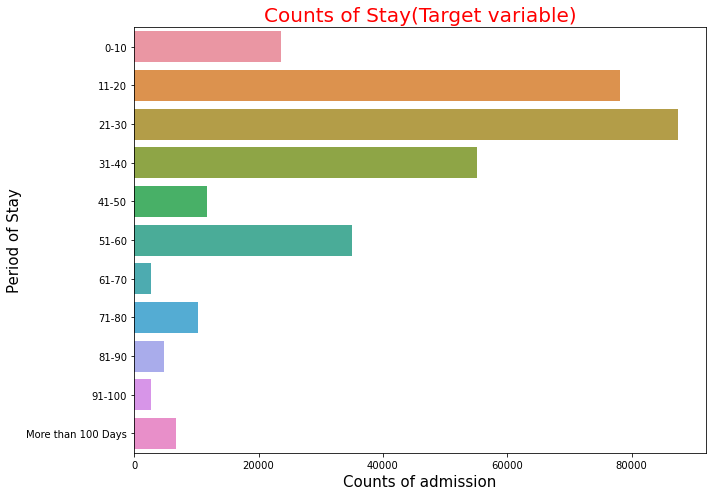

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 종속변수인 재원일수 순서화 시키기
stay_order = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80',
             '81-90','91-100','More than 100 Days']
train['Stay'] = pd.Categorical(train['Stay'], categories=stay_order, ordered=True)

plt.figure(figsize=(10,7))
sns.countplot(data=train, y='Stay')
plt.title('Counts of Stay(Target variable)', fontsize=20, color='red')
plt.xlabel('Counts of admission', fontsize=15)
plt.ylabel('Period of Stay', fontsize=15)
plt.tight_layout()
plt.show()

- class imbalance 존재
    * 향후 모델링시 클래스 불균형 해결 문제 고려해야 함<br><br>
    
- 11개의 클래스 중 **가장 많은** 재원일수 상위 5개
    * 21-30일
    * 11-20일
    * 31-40일
    * 51-60일
    * 0- 10일

## 가설 설정(중요도 순서로 재배열하기)<br>

<font size=4>**EDA Agenda**</font>

- 병원 유형id, 병원 위치 도시id, 지역 id에 따라 재원기간 수 차이를 보일 것이다.
- 병원에서 이용가능한 여분의 병실 수가 적을수록 재원기간 수는 짧을 것이다.
- 입원 환자의 질병에 따라 재원기간 수가 유의미한 차이를 보일 것이다.
    * 이 때, 입원 환자의 질병 종류는 해당 입원을 관리하고 있는 부서 종류로 추측 가능
- 침실 등급에 따라 재원 기간 수가 유의미한 차이를 보일 것이다.
- 환자 입원 유형과 입원 당일 질병의 심각성 간의 관계를 살펴보고 이 변수들과 재원기간 수와 관계가 있는지 살펴보기
- 환자 연령이 높을수록 재원기간 수가 길 것이다.
- 기타 탐색해볼 것
    * 병실 유형과 시설 id에 따라 재원기간 수 차이 -> **4번째 가설검정**에서 동시 실행
    * 환자 거주 도시와 병원이 위치한 도시가 동일한 환자 비율
    * 환자와 동반된 방문객 수에 따라 재원기간 수 차이

### 첫 번째 가설

- ``병원 유형 code, 병원 위치 도시 code, 병원 위치 지역 code에 따라 재원기간 수 차이를 보일 것이다.``
- 병원 유형별(ex.종합병원, 상급종합병원 등) 또는 지역별로 병원의 크기가 다를 것이기 때문에 이는 결국 병상의 개수에도 직접적으로 연결된다. 병상의 개수가 많을수록 병상의 개수는 많을 것이며 이는 결국 재원일수와도 관련될 것이다.

In [7]:
# 관련있는 변수들만 추출
# 병원 유형 code, 병원 위치 도시 code, 지역 code, 여분 병실 수, 연령, 재원일수(종속변수) 만 추출
cols = ['Hospital_type_code','City_Code_Hospital','Hospital_region_code',
       'Available Extra Rooms in Hospital', 'Age', 'Stay']
hospital_df = train[cols]
hospital_df.shape

(318438, 6)

In [8]:
# 범주형 변수별 unique한 값들 살펴보기
cols = ['Hospital_type_code','City_Code_Hospital','Hospital_region_code', 'Age', 'Stay']
for col in cols:
    unique_val = hospital_df[col].unique()
    nunique_val = hospital_df[col].nunique()
    print(f"{col} 변수의 unique한 값 종류 개수:{nunique_val}\n{col} 변수의 unique한 값 종류들:\n{unique_val}")
    print('-'*40)

Hospital_type_code 변수의 unique한 값 종류 개수:7
Hospital_type_code 변수의 unique한 값 종류들:
['c' 'e' 'b' 'a' 'f' 'd' 'g']
----------------------------------------
City_Code_Hospital 변수의 unique한 값 종류 개수:11
City_Code_Hospital 변수의 unique한 값 종류들:
[ 3  5  1  2  6  9 10  4 11  7 13]
----------------------------------------
Hospital_region_code 변수의 unique한 값 종류 개수:3
Hospital_region_code 변수의 unique한 값 종류들:
['Z' 'X' 'Y']
----------------------------------------
Age 변수의 unique한 값 종류 개수:10
Age 변수의 unique한 값 종류들:
['51-60' '71-80' '31-40' '41-50' '81-90' '61-70' '21-30' '11-20' '0-10'
 '91-100']
----------------------------------------
Stay 변수의 unique한 값 종류 개수:11
Stay 변수의 unique한 값 종류들:
[0-10, 41-50, 31-40, 11-20, 51-60, ..., 71-80, More than 100 Days, 81-90, 61-70, 91-100]
Length: 11
Categories (11, object): [0-10 < 11-20 < 21-30 < 31-40 ... 71-80 < 81-90 < 91-100 < More than 100 Days]
----------------------------------------


In [9]:
# 추출한 변수들 결측치 확인
hospital_df.isnull().sum()

Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Age                                  0
Stay                                 0
dtype: int64

In [10]:
#수치형 변수이어야 하는데 범주형 type으로 되어 있으며 whitespace로 결측치가 되어있을 수도 있으니 변수별 dtype 체크
hospital_df.dtypes

Hospital_type_code                     object
City_Code_Hospital                      int64
Hospital_region_code                   object
Available Extra Rooms in Hospital       int64
Age                                    object
Stay                                 category
dtype: object

- Age, Stay는 범위(range)화 되어 있어서 범주형 변수인게 맞음

---

#### 병원 유형과 재원일수 간의 독립성 검정

In [11]:
# 병원 유형 id와 Stay 재원일수 범주형 변수간의 카이제곱 검정
group_df = hospital_df.groupby(['Hospital_type_code','Stay']).agg({'Stay':'count'}).rename(columns={'Stay':'counts'}).reset_index().set_index('Hospital_type_code')
pivot_df = group_df.pivot_table(index=group_df.index, values='counts',
                    columns='Stay')
pivot_df

Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Hospital_type_code,,,,,,,,,,,
a,10559,39807,40286,23974,4111,14617,924,3722,1890,962,2573
b,5145,13933,19541,12385,3893,6909,917,2608,1026,783,1806
c,3588,10318,12526,8222,1872,5176,430,1611,725,439,1021
d,1314,4423,5527,3706,760,2713,186,761,421,180,398
e,1805,6644,6524,4060,764,2832,197,824,395,218,507
f,1023,2332,1897,2093,204,1960,44,482,254,138,276
g,170,682,1190,719,139,811,46,246,127,45,102


In [12]:
# 병원 type별로 
from scipy.stats import chi2_contingency
chi2, p, df, expected = chi2_contingency([pivot_df.iloc[0], pivot_df.iloc[1], pivot_df.iloc[2],
                                         pivot_df.iloc[3], pivot_df.iloc[4], pivot_df.iloc[5],
                                         pivot_df.iloc[6]])
print(f"- 카이제곱 통계량: {chi2 :.4f}\n- P-value: {p}")
expected_df = pd.DataFrame(np.round(expected,0), columns=pivot_df.columns, index=pivot_df.index)
expected_df

- 카이제곱 통계량: 5540.6404
- P-value: 0.0


Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Hospital_type_code,,,,,,,,,,,
a,10631.0,35194.0,39406.0,24844.0,5289.0,15772.0,1236.0,4618.0,2179.0,1245.0,3010.0
b,5111.0,16918.0,18943.0,11943.0,2543.0,7582.0,594.0,2220.0,1047.0,599.0,1447.0
c,3404.0,11270.0,12619.0,7956.0,1694.0,5051.0,396.0,1479.0,698.0,399.0,964.0
d,1511.0,5003.0,5602.0,3532.0,752.0,2242.0,176.0,657.0,310.0,177.0,428.0
e,1836.0,6078.0,6806.0,4291.0,913.0,2724.0,213.0,798.0,376.0,215.0,520.0
f,793.0,2626.0,2941.0,1854.0,395.0,1177.0,92.0,345.0,163.0,93.0,225.0
g,317.0,1049.0,1175.0,741.0,158.0,470.0,37.0,138.0,65.0,37.0,90.0


- P-value값이 0.0으로 카이제곱겁정의 귀무가설을 기각. 즉, Hospital_type_code와 Stay변수간에 독립적이지 않고 연관이 있다.

#### 병원 유형 코드와 여분 병실 수치를 이용해 병원 유형 추론해보기

- 현재 병원 유형 코드가 익명화 되어 있는 상태. 따라서 아래와 같은 내용을 기반으로 병원의 크기를 추론해보자.
- 우선 병원 유형별로 입원환자들이 얼마나 많았는지 살펴보고 이를 활용해 여분 병실 수를 비율로 나타내보기
- 예를들어, 10명이 입원한 병원의 여분 병실수가 100개인 A병원과 1000명이 입원한 병원의 여분 병실수가 100개인 B병원 둘 중 병상회전율이 좋은 당연히 B병원일 것이다. 이를 알아보기 위한 분석 수행  
- 따라서 공식은 ``'(입원환자 수 / 여분 병실수) * 100'`` 을 이용. ``이 값이 높을수록 병원의 병상회전율이 클 것``이다.
- 단, 병상회전율 공식을 사용하기엔 입원, 퇴원 환자수와 정확한 재원일수를 알아야 하는데 알 수 없음. 따라서 임의적으로 공식을 만듦..(한계점)

In [13]:
hospital_code_count = hospital_df.groupby(['Hospital_type_code']).agg({'Hospital_type_code':'count'}).rename(columns={'Hospital_type_code':'count'})
hospital_code_count

,count
Hospital_type_code,
a,143425
b,68946
c,45928
d,20389
e,24770
f,10703
g,4277


In [14]:
type_sum_df = hospital_df.groupby('Hospital_type_code').agg({'Available Extra Rooms in Hospital':'sum'}).rename(columns={'Available Extra Rooms in Hospital':'sum'})
type_sum_df

,sum
Hospital_type_code,
a,468336
b,224631
c,145676
d,65173
e,74450
f,28274
g,11706


In [15]:
# 위 두 데이터프레임 concat 하기
concat_df = pd.concat([hospital_code_count, type_sum_df], axis=1)
concat_df['ratio'] = (concat_df['count'] / concat_df['sum']) * 100
concat_df = concat_df.sort_values(by='ratio', ascending=False)
concat_df

,count,sum,ratio
Hospital_type_code,,,
f,10703,28274,37.854566
g,4277,11706,36.536819
e,24770,74450,33.270651
c,45928,145676,31.527499
d,20389,65173,31.284428
b,68946,224631,30.693003
a,143425,468336,30.624381


- 결과 해석하기가 애매모호..
---

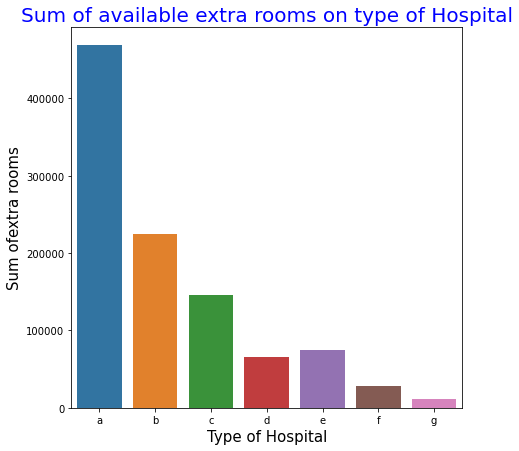

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

type_sum_df = hospital_df.groupby('Hospital_type_code').agg({'Available Extra Rooms in Hospital':'sum'}).rename(columns={'Available Extra Rooms in Hospital':'sum'})

plt.figure(figsize=(7,7))
sns.barplot(data=type_sum_df, x=type_sum_df.index, y='sum')
plt.title('Sum of available extra rooms on type of Hospital', fontsize=20, color='blue')
plt.xlabel('Type of Hospital', fontsize=15)
plt.ylabel('Sum ofextra rooms', fontsize=15)
plt.show()

- a병원이 압도적으로 여분의 병실이 많았다. 대체 ``a병원은 어디지역에 위치해 있는지 확인해보자.``
- ``b,c 병원의 위치 파악하기``
- ``d,e,f,g 병원의 위치 파악하기``

#### 병원들 유형에 따라 병원이 어떤 지역과 도시에 위치해있는지 살펴보기

In [17]:
# 위치 지역(region) 파악
region_df = hospital_df.groupby(['Hospital_type_code','Hospital_region_code']).agg({'Hospital_type_code':'count'}).rename(columns={'Hospital_type_code':'count'})
region_df = region_df.reset_index()
region_df

,Hospital_type_code,Hospital_region_code,count
0,a,X,91429
1,a,Y,46760
2,a,Z,5236
3,b,X,17137
4,b,Y,51809
5,c,Z,45928
6,d,Y,8879
7,d,Z,11510
8,e,X,24770
9,f,Y,10703


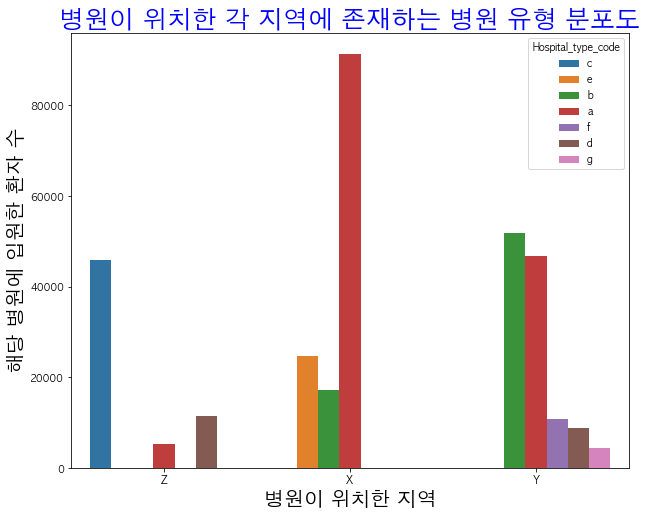

In [18]:
plt.rc('font', family='AppleGothic')
plt.figure(figsize=(10,8))
sns.countplot(data=hospital_df, x='Hospital_region_code', hue='Hospital_type_code')
plt.title("병원이 위치한 각 지역에 존재하는 병원 유형 분포도", fontsize=25, color='blue')
plt.xlabel('병원이 위치한 지역', fontsize=20)
plt.ylabel('해당 병원에 입원한 환자 수', fontsize=20)
plt.show()

- X라는 지역에는
    * a라는 유형의 병원에 입원한 환자가 압도적으로 가장 많으며 적은 입원환자 숫자를 기록했지만 b, e 유형의 병원에도 입원
- Y라는 지역에는
    * a,b 유형의 병원에 입원환자 대부분이 입원했으며 소수의 환자들은 f,d,g 유형의 병원에 입원
- Z라는 지역에는
    * c라는 유형의 병원에 입원환자 대부분이 입원했으며 소수의 환자들은 a, d 유형의 병원에 입원<br><br>
    
- 따라서,
    * **X지역**에는 a 유형의 병원이 많이 존재하며 b, e 유형의 병원은 소수 존재
    * **Y지역**에는 a,b 유형의 병원이 대부분 존재하며, f,d,g 유형의 병원은 소수 존재
    * **Z지역**에는 c 유형의 병원이 대부분 존재하며, a, d 유형의 병원이 소수 존재

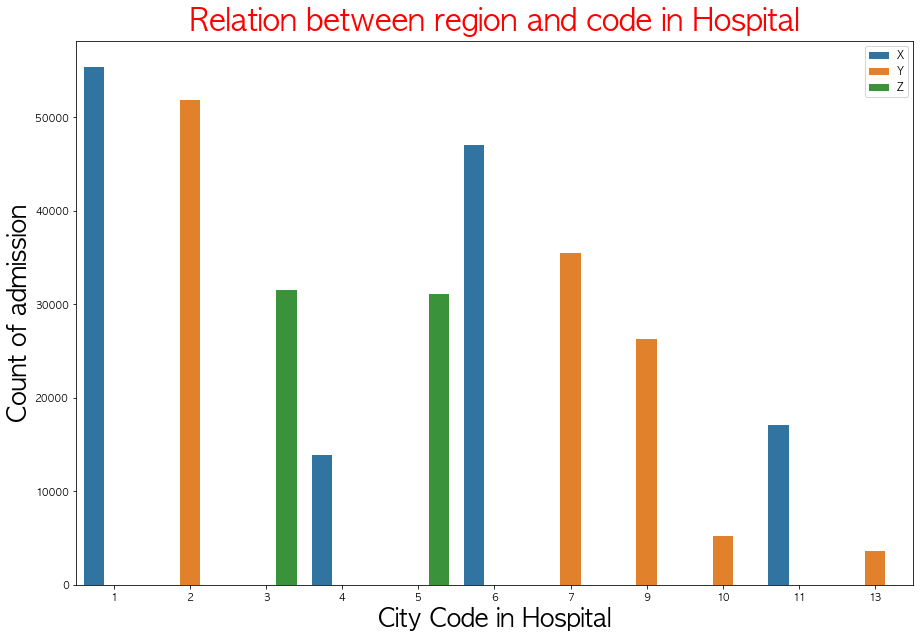

In [19]:
# 병원이 위치한 도시코드와 지역코드들이 서로 어디에 속하는지 살펴보기
# 참고로 Region(지역)이 City(도시)보다 상위의 개념
region_city_df = hospital_df.groupby(['Hospital_region_code','City_Code_Hospital']).agg({'City_Code_Hospital':'count'}).rename(columns={'City_Code_Hospital':'count'}).reset_index()

plt.figure(figsize=(15,10))
sns.barplot(data=region_city_df, x='City_Code_Hospital', y='count', hue='Hospital_region_code')
plt.title('Relation between region and code in Hospital', fontsize=30, color='red', pad=10)
plt.xlabel('City Code in Hospital', fontsize=25)
plt.ylabel('Count of admission', fontsize=25)
plt.legend(loc='upper right')

#### 병원이 위치한 지역별 입원 환자수를 기반으로 해당 지역에 거주하는 인구 수 추론

In [20]:
# 병원 지역별 입원 환자 수는 결국 그 지역에 거주하는 인구수랑 비례할 것이다.
admi_count = hospital_df.groupby(['Hospital_region_code']).agg({'Hospital_region_code':'count'}).rename(columns={'Hospital_region_code':'count'})
admi_count = admi_count.sort_values(by='count', ascending=False)
admi_count

,count
Hospital_region_code,
X,133336
Y,122428
Z,62674


- ``X지역 : 1번, 4번, 6번, 11번 도시``
- ``Y지역 : 2번, 7번, 9번, 10번, 13번 도시``
- ``Z지역 : 3번, 5번 도시``<br><br>

- X지역에는 a 유형의 병원이 많이 존재하며 e, b 유형의 병원은 소수 존재
- Y지역에는 a,b 유형의 병원이 대부분 존재하며, f,d,g 유형의 병원은 소수 존재
- Z지역에는 c 유형의 병원이 대부분 존재하며, a, d 유형의 병원이 소수 존재
<br><br>

**위 3가지 분석으로 보아**
- X지역에는 1,4,6,11번 도시가 속하며 1,4,6,11번 도시에는 ``a유형의 병원이 대부분``. b,e 유형도 극소수 존재
- Y지역에는 2,7,9,10,13번 도시가 속하며 ``b, a유형의 병원이 대부분``. f,d,g 유형도 극소수 존재
- Z지역에는 3,5번 도시가 속하며 ``c 유형의 병원이 대부분``. a,d 유형도 극소수 존재
<br><br>
- **``X,Y 지역에 사람들이 가장 많이 살며, X,Y 지역의 절반에 해당하는 인구수가 Z지역에 살 것으로 추측``**
- 따라서, **``a유형의 병원은 X,Y지역에 모두 대부분 자리잡고 있으며 대형병원일 가능성이 높다!``**
- 또한 Y지역에는 b 유형, Z지역에는 c 유형의 병원이 대부분이며 이 병원들에 대한 크기는 추론 불가

#### 첫 번째 가설 검정
- 병원 유형과 재원일수 변수간에 독립적인 관계가 아님이 증명
- a유형의 크기에 대해서는 ``대형병원``일 것임을 추론
- 하지만 병원 유형과 병원 지역, 병원 위치의 익명화로 정확이 어떤 병원 유형인지, 병원 위치가 어디인지는 파악 불가

### 두 번째 가설
- ``병원에서 이용가능한 여분의 병실 수가 적을수록 재원기간 수는 짧을 것이다.``


In [21]:
# 여분 병실 이용 수, 재원일수 변수 추출
extra_rooms = train[['Available Extra Rooms in Hospital','Stay']]
# 재원일수 level이 서열척도 이므로 긴 재원일수면 높은 scala값으로 레이블링
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action='ignore')

encoder = LabelEncoder()
extra_rooms['Stay'] = encoder.fit_transform(extra_rooms['Stay'])
extra_rooms['Stay'].unique()

array([ 0,  4,  3,  1,  5,  2,  7, 10,  8,  6,  9])

In [22]:
extra_rooms.columns

Index(['Available Extra Rooms in Hospital', 'Stay'], dtype='object')

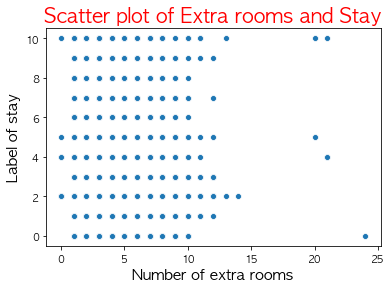

In [23]:
# 산점도로 살펴보기
sns.scatterplot(data=extra_rooms, x='Available Extra Rooms in Hospital', y='Stay')
plt.title('Scatter plot of Extra rooms and Stay', fontsize=20, color='red')
plt.xlabel('Number of extra rooms', fontsize=15)
plt.ylabel('Label of stay', fontsize=15)
plt.show()

- 산점도로 보아 두 변수간의 선형관계는 보이지 않는 듯 하다.

<AxesSubplot:>

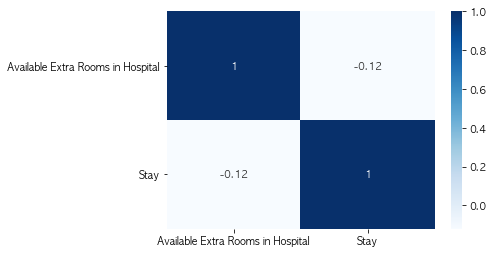

In [24]:
# 두 변수간 상관계수로 관계 살펴보기
corr = extra_rooms.corr()
sns.heatmap(corr, cmap='Blues', annot=True)

- 상관계수값이 -0.12로 두 변수간의 관계는 없는 것으로 판단

#### 두 번째 가설 검정

- 병원의 여분 병실수와 재원일수간에는 관계가 없는 것으로 판단
- 따라서 두 번째 가설 기각!

### 세 번째 가설

- 입원 환자의 질병에 따라 재원기간 수가 유의미한 차이를 보일 것이다.
    * 이 때, 입원 환자의 질병 종류는 해당 입원을 관리하고 있는 부서 종류로 추측 가능

- 우선 Department의 level값들을 살펴보면서 어떤 부서가 있는지 살펴보자

In [25]:
train['Department'].unique()

array(['radiotherapy', 'anesthesia', 'gynecology', 'TB & Chest disease',
       'surgery'], dtype=object)

- <a href='https://ko.wikipedia.org/wiki/%EB%B0%A9%EC%82%AC%EC%84%A0%EC%A2%85%EC%96%91%ED%95%99%EA%B3%BC'>radiotherapy</a> : 방사선종양학과(암 환자 치료 부서)
- <a href='https://ko.wikipedia.org/wiki/%EB%A7%88%EC%B7%A8'>anesthesia</a> : 마취통증의학과(마취부서)
- <a href='https://ko.wikipedia.org/wiki/%EC%97%AC%EC%84%B1%EC%9D%98%ED%95%99%EA%B3%BC'>gynecology</a> : 여성의학과 또는 부인과는 여성의 생식 기관을 다루는 의학 분야
- <a href='http://www.amc.seoul.kr/asan/healthinfo/disease/diseaseDetail.do?contentId=31528'>TB & Chest disease</a> : 만성폐쇄성 폐질환
- surgery : 외과수술

#### 이원 카이스퀘어 검정을 통해 두 범주형 변수간의 관계 검정

In [26]:
department = train[['Department','Stay']]
group_df = department.groupby(['Stay','Department']).agg({'Department':'count'}).rename(columns={'Department':'count'}).reset_index()
pivot_df = pd.pivot_table(data=group_df, index='Stay', values='count', columns='Department')
pivot_df.head()

Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Stay,,,,,
0-10,791,1519,18849,2379,66
11-20,2379,8823,59690,6988,259
21-30,2618,8950,68383,7263,277
31-40,1753,4958,43535,4713,200
41-50,300,851,9671,879,42


In [27]:
# 카이제곱검정으로 넣어줄 각 행 리스트 컴프리헨션으로 미리 넣어서 추후에 카이제곱검정 인자에 넣어줄 변수명 입력 불편함 줄여주기
chisq2_arg = [pivot_df.iloc[i].tolist() for i in range(pivot_df.shape[0])]
chisq2_arg

[[791, 1519, 18849, 2379, 66],
 [2379, 8823, 59690, 6988, 259],
 [2618, 8950, 68383, 7263, 277],
 [1753, 4958, 43535, 4713, 200],
 [300, 851, 9671, 879, 42],
 [1047, 2527, 27989, 3256, 199],
 [76, 173, 2226, 264, 5],
 [294, 703, 8165, 1043, 49],
 [140, 384, 3748, 528, 38],
 [64, 156, 2269, 256, 20],
 [124, 605, 4961, 947, 46]]

In [28]:
from scipy.stats import chi2_contingency

chi2, p, df, expected = chi2_contingency(chisq2_arg)
expected_df = pd.DataFrame(data=np.round(expected,0), columns=pivot_df.columns, index=pivot_df.index)

print(f"카이제곱통계량: {chi2: .4f}\nP-value: {p}\n자유도: {df}")
print()
expected_df

# 자유도 = (Stay level개수 -1) * (Department level개수 -1) = (11-1)*(5-1) = 40

카이제곱통계량:  1618.9226
P-value: 0.0
자유도: 40



Department,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
Stay,,,,,
0-10,711.0,2198.0,18493.0,2114.0,89.0
11-20,2352.0,7275.0,61219.0,6997.0,295.0
21-30,2634.0,8146.0,68546.0,7835.0,330.0
31-40,1660.0,5136.0,43215.0,4939.0,208.0
41-50,354.0,1093.0,9200.0,1052.0,44.0
51-60,1054.0,3260.0,27435.0,3136.0,132.0
61-70,83.0,255.0,2150.0,246.0,10.0
71-80,309.0,955.0,8034.0,918.0,39.0
81-90,146.0,450.0,3790.0,433.0,18.0


- P-value값이 유의수준 0.05보다 작으므로 귀무가설을 기각
- 따라서, 재원일수(Stay)와 부서(Department)간에 관계가 있음
- 하지만 자세하게 시각화를 해서 얼마나 관계가 있는지 파악할 필요. 통계 검정 하나만으로 변수 관계여부 판단의 절대적 기준이 될 순 없음

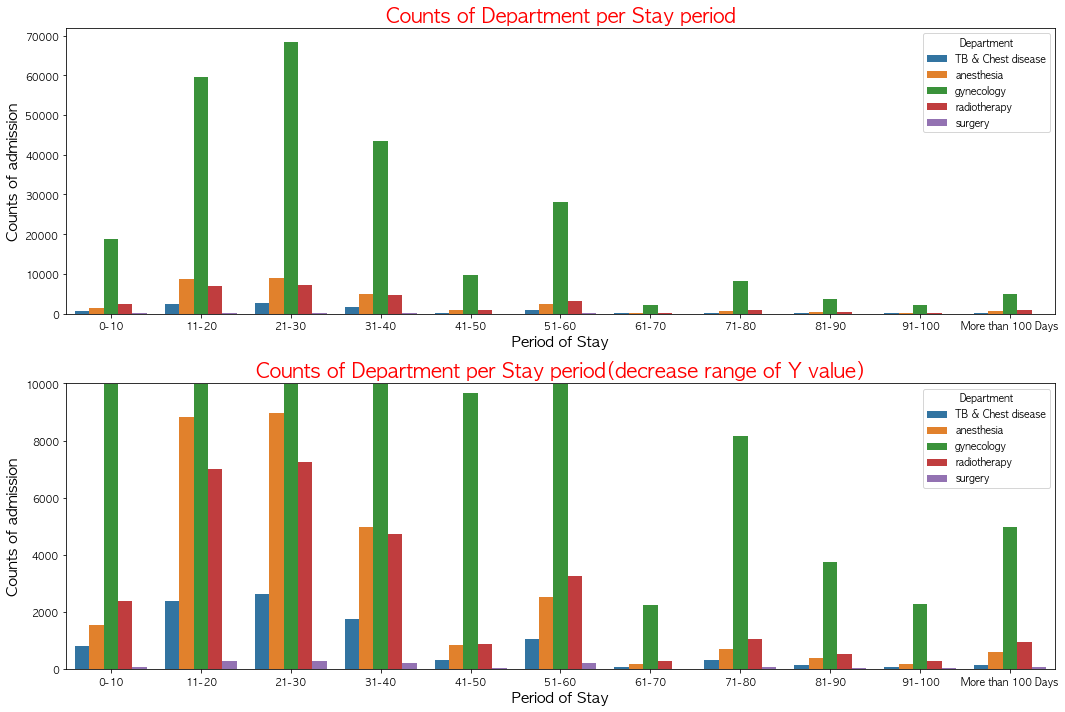

In [29]:
# 부서별로 재원일수의 빈도수를 살펴보자
fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=2)
sns.barplot(data=group_df, x='Stay', y='count', hue='Department', ax=axes[0])
sns.barplot(data=group_df, x='Stay', y='count', hue='Department', ax=axes[1])

axes[0].set_title('Counts of Department per Stay period', fontsize=20, color='red')
axes[0].set_xlabel('Period of Stay', fontsize=15)
axes[0].set_ylabel('Counts of admission', fontsize=15)

axes[1].set_title('Counts of Department per Stay period(decrease range of Y value)', fontsize=20, color='red')
axes[1].set_xlabel('Period of Stay', fontsize=15)
axes[1].set_ylabel('Counts of admission', fontsize=15)
axes[1].set_ylim(0, 10000)

plt.tight_layout()
plt.show()

- 첫번째 그래프
    * 여성 생식기관을 다루는 gynecology가 모든 재원일수중 압도적으로 많은 걸로 보아 ``입원환자들의 대부분은 여성인 것``으로 파악!


- 두번째 그래프(가장 많은 gynecology를 제외한 부서들의 비교를 위해 y값 축소)
    * 다음으로 가장 많은 것은 마취(anesthesia)와 방사선종양학과(radiotherapy)
        * 방사선종양학과의 많은 빈도수로 인해 ``암 환자들이 많을 것``으로 예상
        * 하지만 마취는 수술 대부분에서 필수적으로 포함되는 부서라 이를 통한 입원환자의 질병 추측은 사실상 어려움..이에 대한 깊은 도메인 지식 필요 ->``조현득 교수님께 '마취 부서로 등록이 되면 보통 무슨 일로 입원을 할까..?'``
    * ``외과수술(surgery)로 입원``하는 환자수는 다른 부서에 비해 상대적으로 ``매우 적은 수치``
    * COPD 같은 경우에는 재원일수 초반에는 많지만 오랜 기간의 재원일수에는 점점 적어지는 수치...인가? 이것도 애매모호..

#### 각 재원일수의 count 합을 구하여 각 재원일수 level 마다 Department 비율 변수 추가하기

- ``모델링시 파생변수 가능성? 고려해보자 추후에..``

In [30]:
# 각 재원일수의 sum이 담겨있는 dict 만들기
stay_lst = group_df.Stay.unique().tolist()
stay_sum_dict = {}

for stay in stay_lst:
    level_sum = group_df.loc[group_df['Stay'] == stay, 'count'].sum()
    stay_sum_dict[stay] = level_sum
stay_sum_dict

{'0-10': 23604,
 '11-20': 78139,
 '21-30': 87491,
 '31-40': 55159,
 '41-50': 11743,
 '51-60': 35018,
 '61-70': 2744,
 '71-80': 10254,
 '81-90': 4838,
 '91-100': 2765,
 'More than 100 Days': 6683}

In [31]:
# 각 재원일수에 맞는 sum 변수 생성
group_df['stay_sum'] = ''
for i in range(len(group_df)):
    group_df.loc[i, 'stay_sum'] = stay_sum_dict[group_df.loc[i, 'Stay']]

In [32]:
# 각 재원일수 sum에 맞는 비율 변수 생성
# object타입으로 반환되서 float형으로 바꿔주어야 함
group_df['ratio_department'] = (group_df['count'] / group_df['stay_sum']) * 100
group_df['ratio_department'] = group_df['ratio_department'].astype(float)
group_df['ratio_department'] = group_df['ratio_department'].round(3)

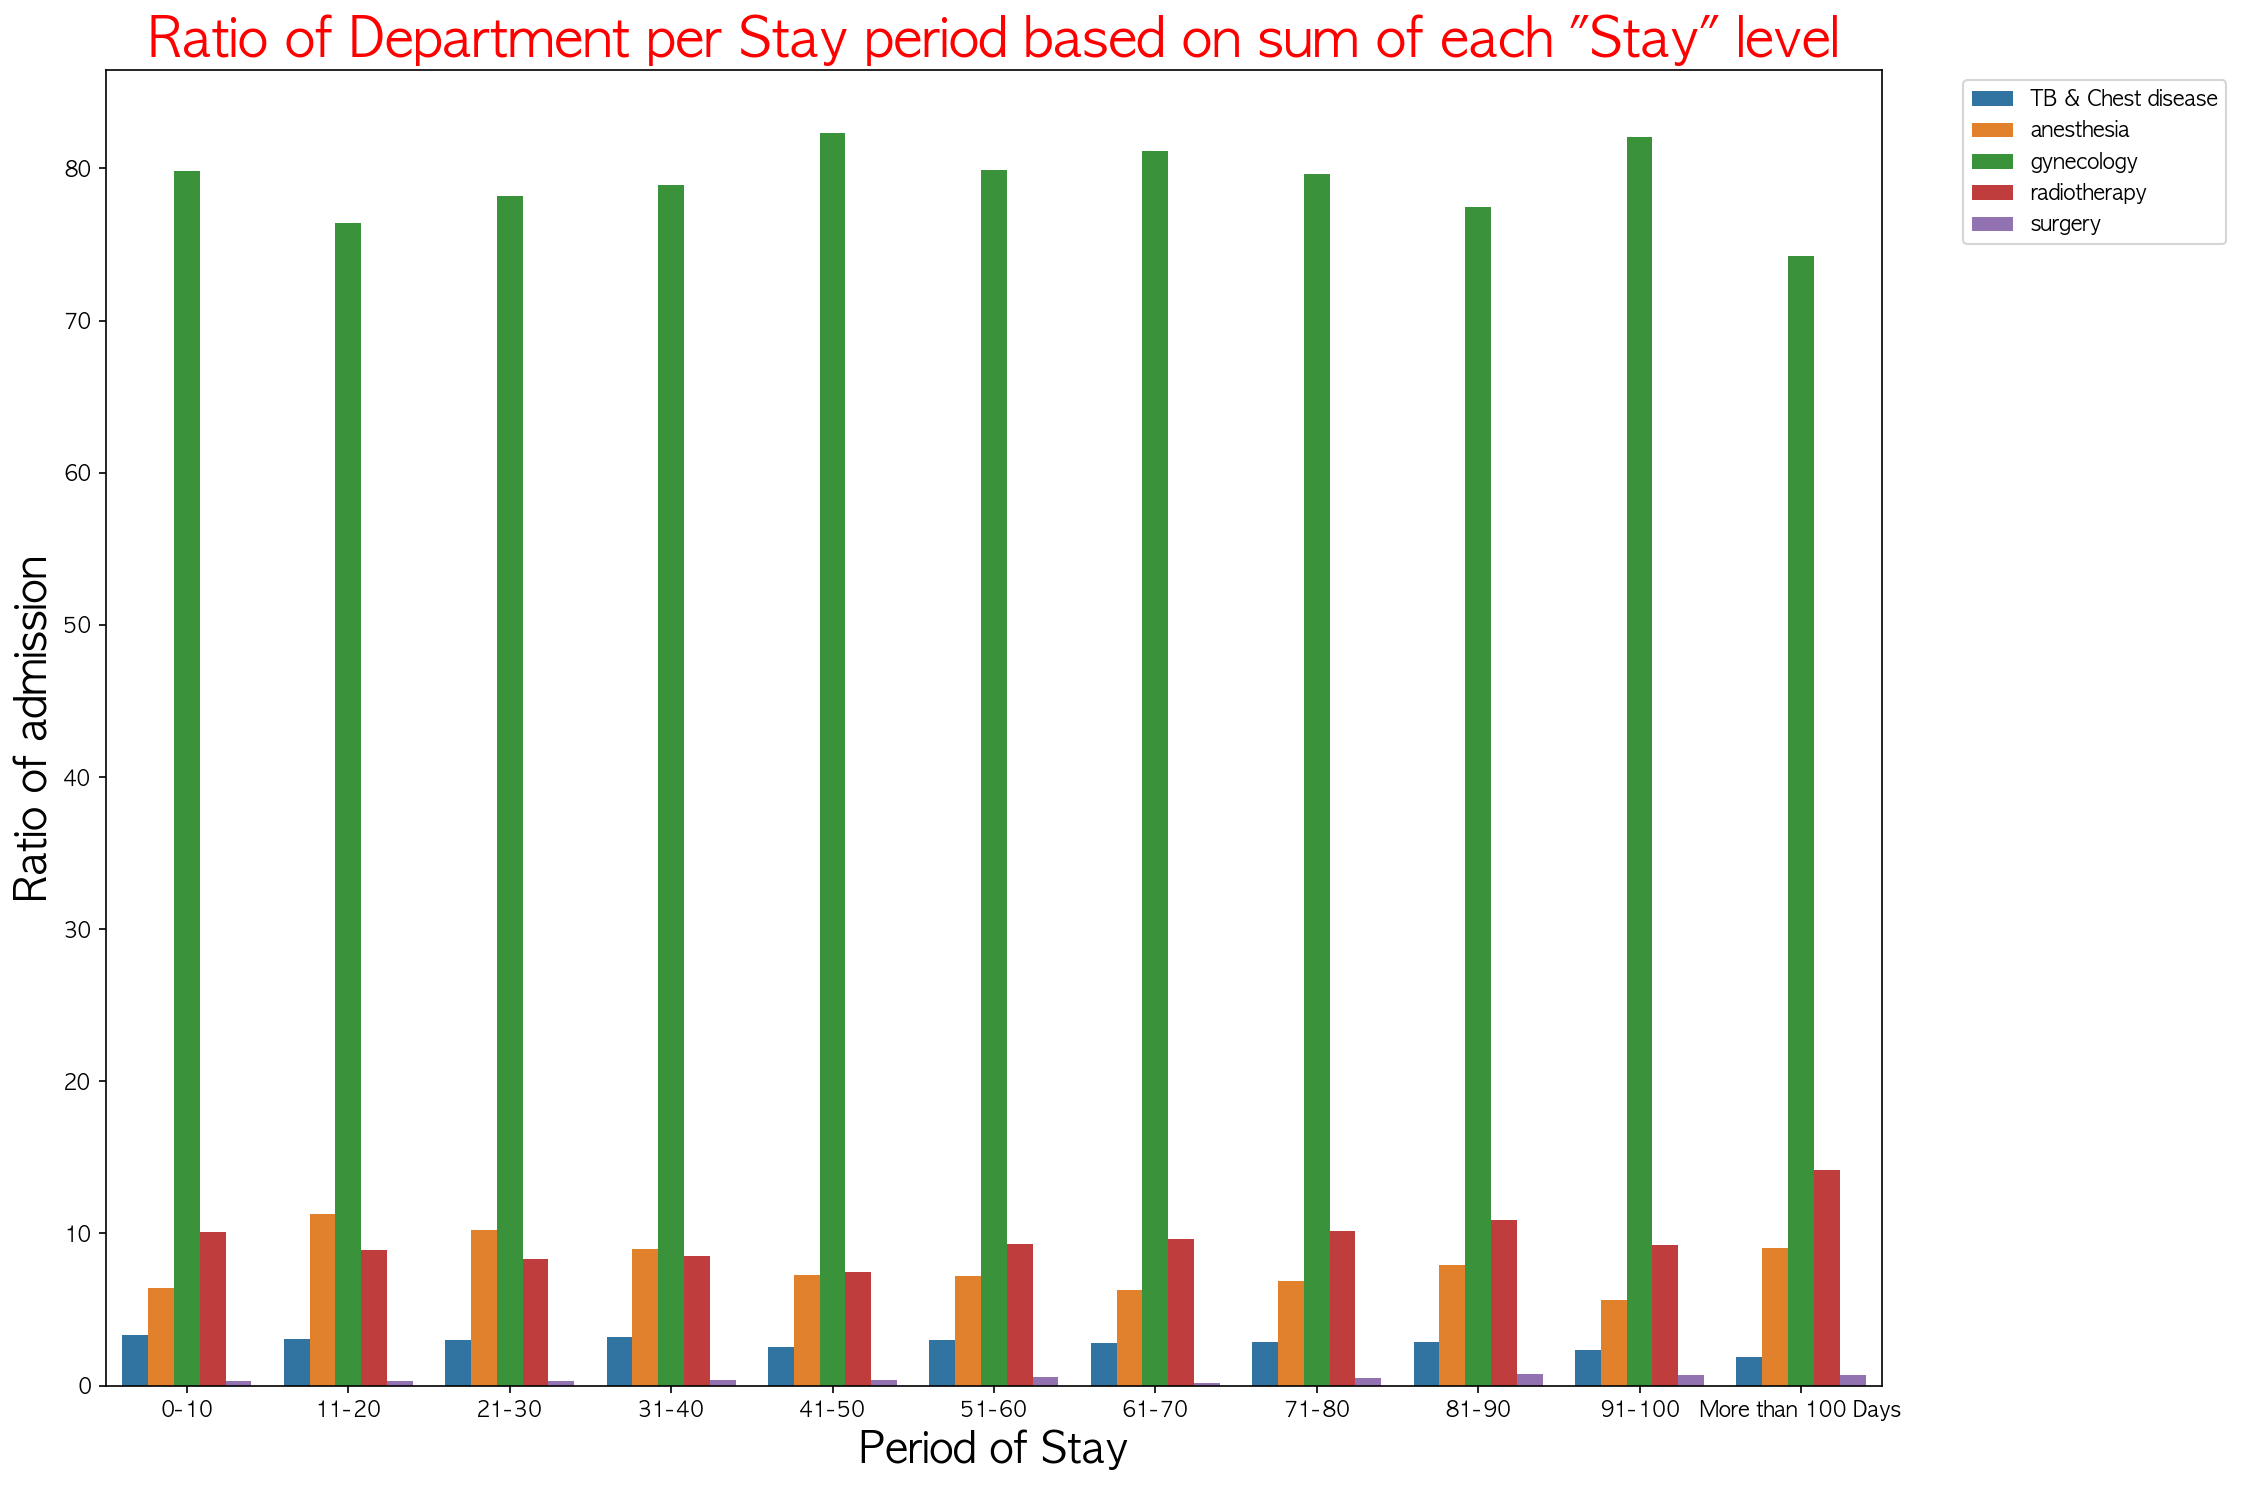

In [33]:
plt.figure(figsize=(15,10), dpi=150)
sns.barplot(data=group_df, x='Stay', y='ratio_department', hue='Department')

plt.title('Ratio of Department per Stay period based on sum of each "Stay" level', fontsize=25, color='red')
plt.xlabel('Period of Stay', fontsize=20)
plt.ylabel('Ratio of admission', fontsize=20)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

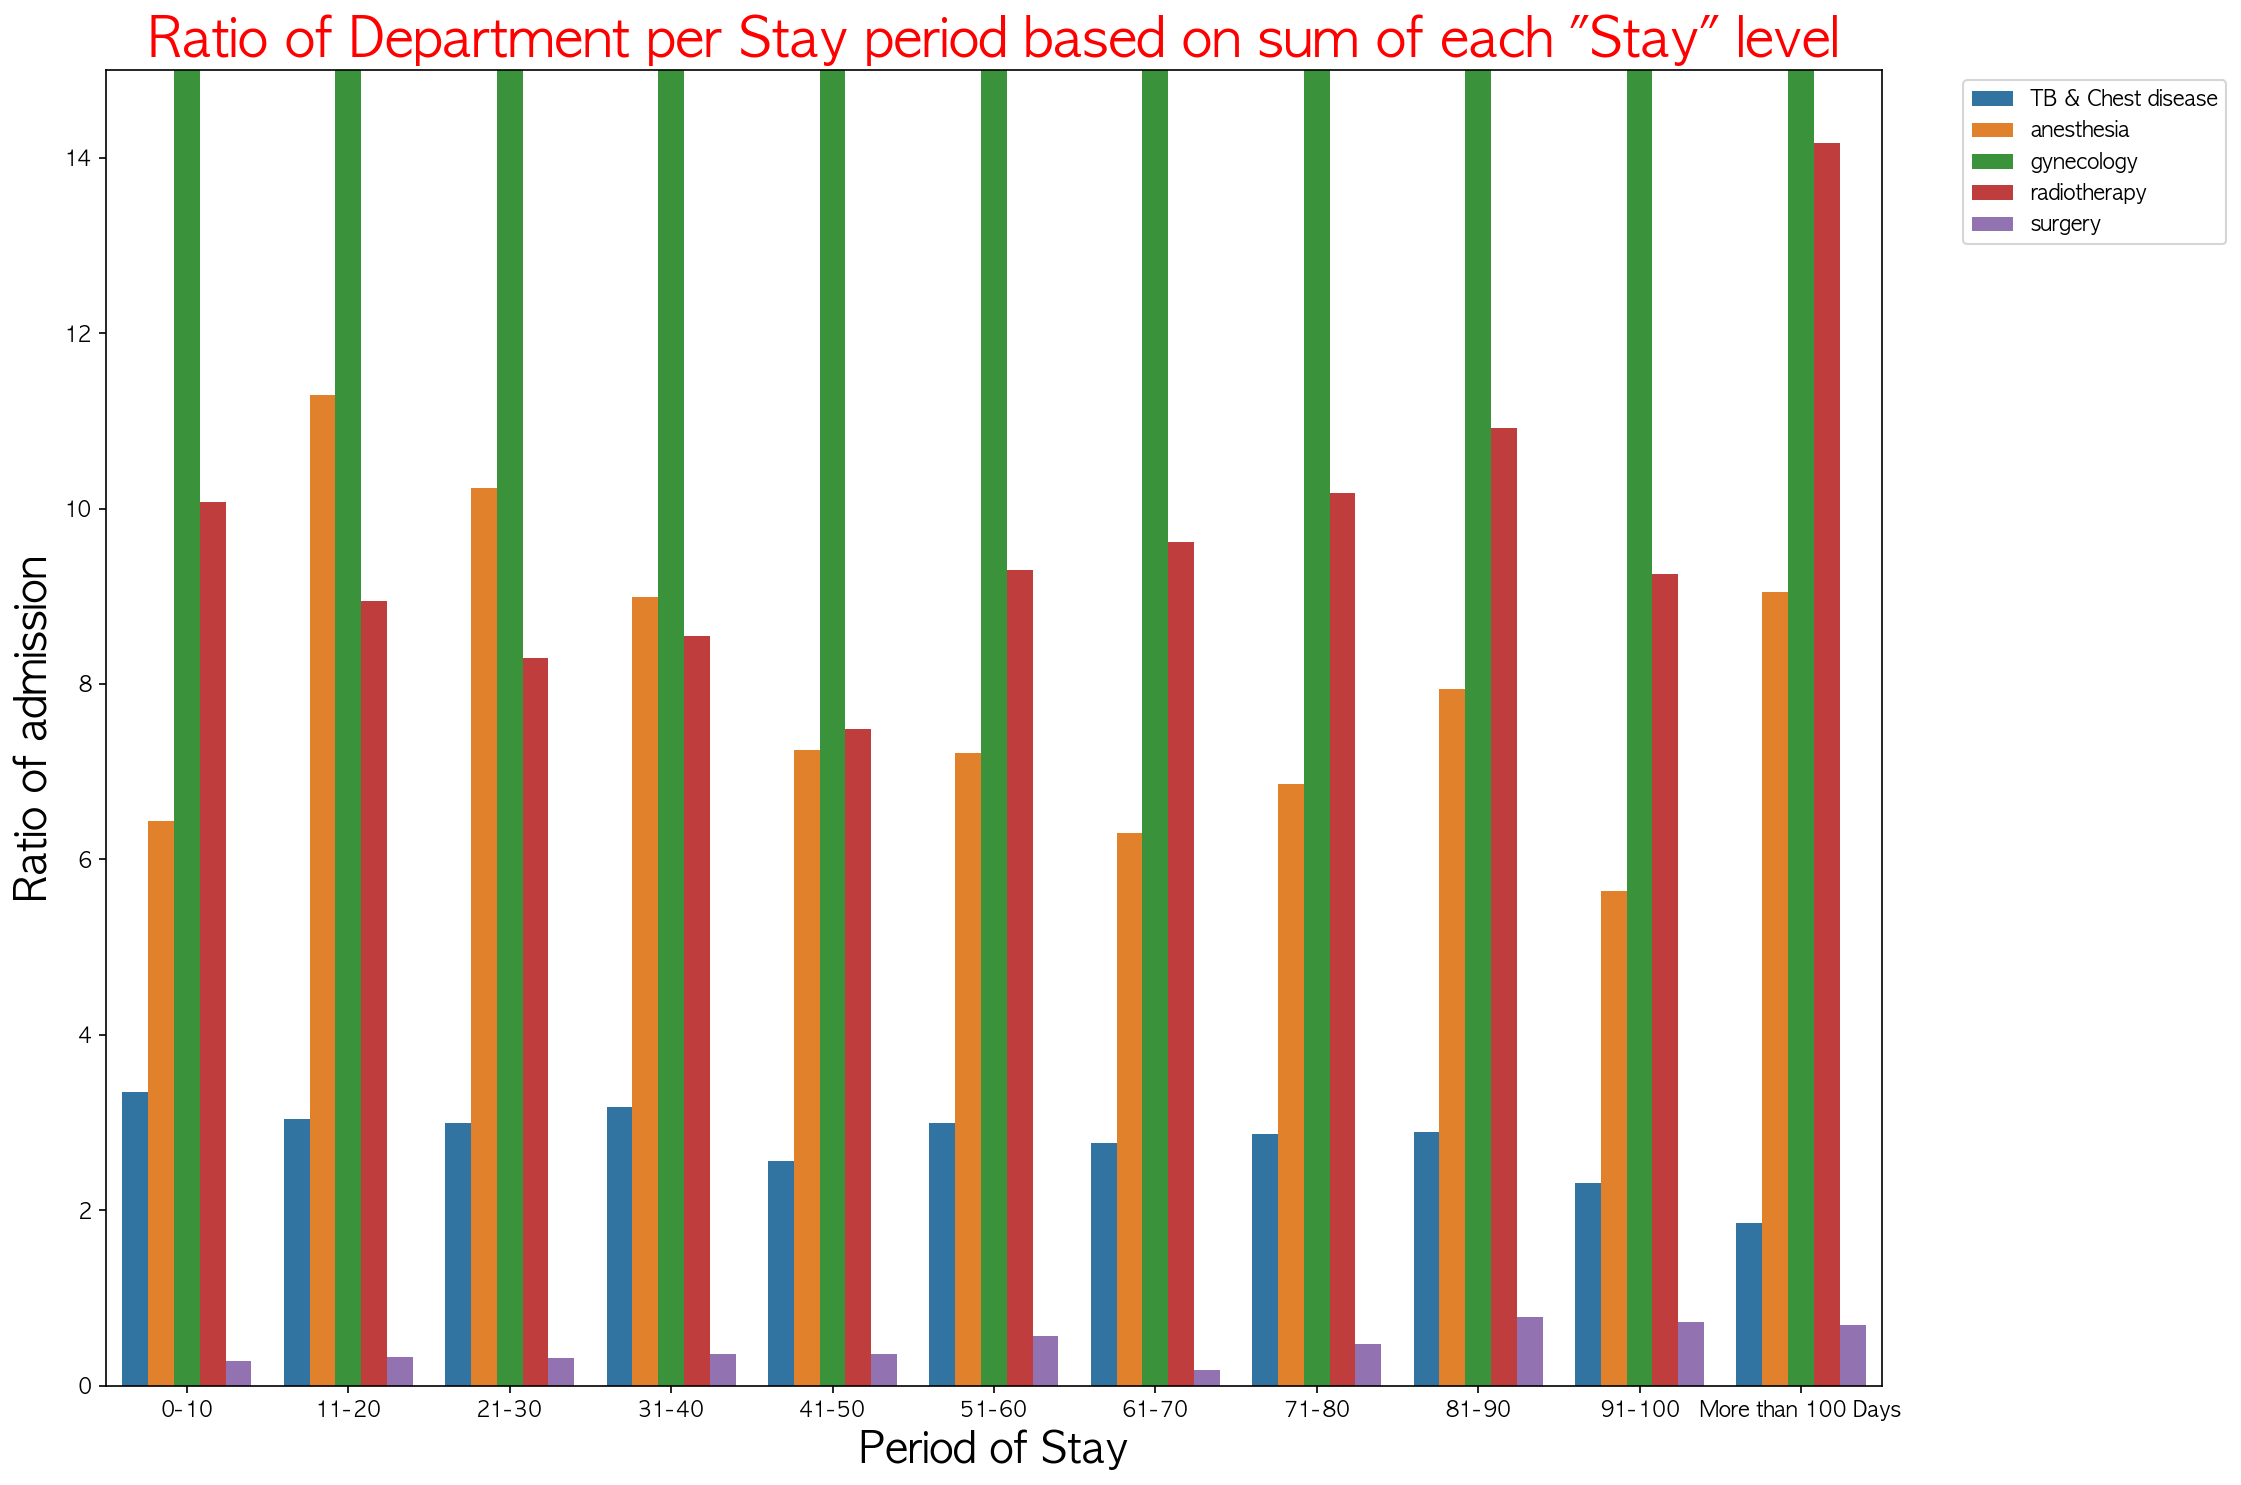

In [34]:
plt.figure(figsize=(15,10), dpi=150)
sns.barplot(data=group_df, x='Stay', y='ratio_department', hue='Department')

plt.title('Ratio of Department per Stay period based on sum of each "Stay" level', fontsize=25, color='red')
plt.xlabel('Period of Stay', fontsize=20)
plt.ylabel('Ratio of admission', fontsize=20)
plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylim(0, 15)
plt.tight_layout()
plt.show()

**비율 그래프 해석 결과**<br><br>
- 1번째 결과 : gynecology(여성의 생식 기관)가 모든 재원일수에 걸쳐서 비율이 압도적으로 가장 많으므로 ``여성 환자가 압도적으로 많을 것``
    * ``이것으로 성별 파생변수 생성할 수도 있을듯!``
- 2번째 결과 : ``radiotherapy(암 관련) 재원일수를 보면 장기간으로 늘어날수록 암환자의 비율이 높아짐!``
    * radiotherapy 부서가 관리하는 입원환자에게 ``암 환자 여부 파생변수 추가``
- 3번째 결과: ``ansthesia는 비율이 올라갔다가 내려갔다가 반복적인 경향``
- 4번째 결과 : ``TB & Chest는 짧은 재원기간 수 일때 들쑥날쑥하지만 71일 대의 재원일수 부터는 낮아지는 경향``
- 5번째 결과 : ``surgery는 51-60일대와 81일대 이상의 재원일수에 가장 많다``

#### 세 번째 가설 검정
- Department 종류(환자 입원 사유)에 따라 재원일 수 차이가 존재한다.(빈도수나 비율로 봐도 모두 차이 존재)

### 네 번째 가설
- 침실(bed) 등급에 따라 재원 기간 수가 유의미한 차이를 보일 것이다.
    * 침실 등급은 병실(Ward) 유형과 병실 시설 코드, 입원 보증금과 연관이 있을 것이므로 3가지 변수 함께 분석 시도

In [35]:
# 병실 유형, 시설코드, 침실 등급, 입원 보증금, 재원일수 총 5가지 데이터 추출
bed_cols = ['Ward_Type','Ward_Facility_Code','Bed Grade','Admission_Deposit','Stay']

bed_df = train[bed_cols]
bed_df.head()

,Ward_Type,Ward_Facility_Code,Bed Grade,Admission_Deposit,Stay
0,R,F,2.0,4911.0,0-10
1,S,F,2.0,5954.0,41-50
2,S,E,2.0,4745.0,31-40
3,R,D,2.0,7272.0,41-50
4,S,D,2.0,5558.0,41-50


In [36]:
# 상관분석을 위해 LabelEncoding으로 재원일수 서열값으로 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
bed_df['Stay'] = encoder.fit_transform(bed_df['Stay'])

#### 수치형 변수인 침실등급, 입원 보증금간의 관계

- 침실등급이 높을수록 입원 보증금이 높은지 살펴보기

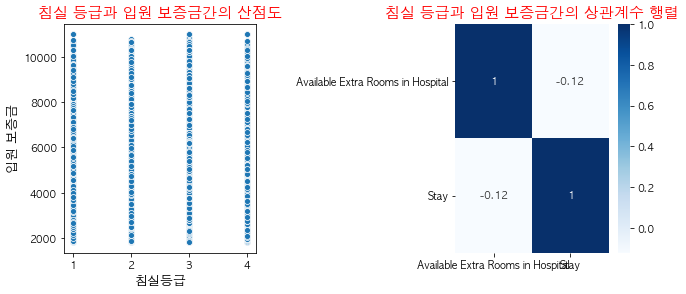

In [37]:
# 침실과 입원 보증금 Scatter plot 그려보고 상관계수 출력
corr_df = bed_df[['Bed Grade', 'Admission_Deposit']].corr()

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1, )
sns.scatterplot(data=bed_df, x='Bed Grade',y='Admission_Deposit', ax=axes[0])
sns.heatmap(corr, cmap='Blues', annot=True, ax=axes[1])

axes[0].set_title('침실 등급과 입원 보증금간의 산점도', fontsize=15, color='red')
axes[0].set_xlabel('침실등급', fontsize=13)
axes[0].set_ylabel('입원 보증금', fontsize=13)

axes[1].set_title('침실 등급과 입원 보증금간의 상관계수 행렬', fontsize=15, color='red')
fig.tight_layout(pad=4)


- 침실 등급과 입원 보증금간의 관계는 없는 것으로 판단

#### 수치형 변수인 침실등급, 입원 보증금과 종속변수(Stay)와의 관계

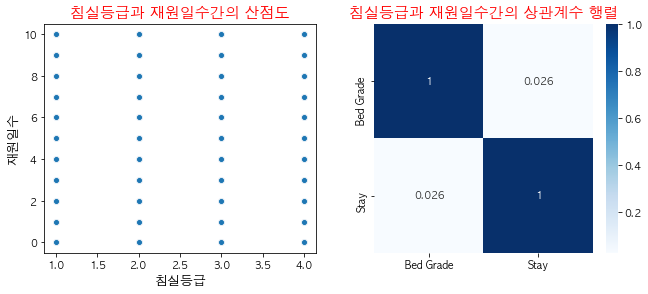

In [38]:
# 침실등급과 종속변수 산점도와 상관계수
corr = bed_df[['Bed Grade', 'Stay']].corr()

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

sns.scatterplot(data=bed_df, x='Bed Grade', y='Stay', ax=axes[0])
sns.heatmap(data=corr, cmap='Blues', annot=True, ax=axes[1])

axes[0].set_title('침실등급과 재원일수간의 산점도', fontsize=15, color='red')
axes[0].set_xlabel('침실등급', fontsize=13)
axes[0].set_ylabel('재원일수', fontsize=13)

axes[1].set_title('침실등급과 재원일수간의 상관계수 행렬', fontsize=15, color='red')
fig.tight_layout(pad=4)


- 침실등급과 재원일수간의 상관관계가 없는 것으로 판단

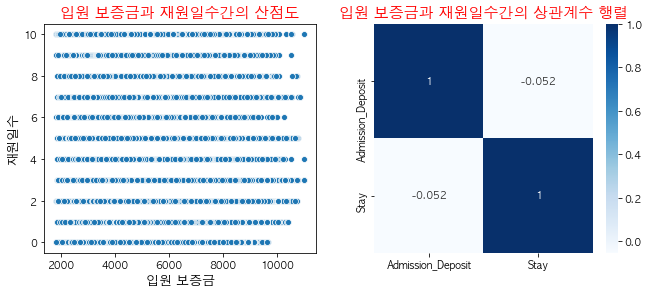

In [39]:
# 입원보증금과 종속변수 산점도와 상관계수
corr = bed_df[['Admission_Deposit', 'Stay']].corr()

fig, axes = plt.subplots(figsize=(10,5), ncols=2, nrows=1)

sns.scatterplot(data=bed_df, x='Admission_Deposit', y='Stay', ax=axes[0])
sns.heatmap(data=corr, cmap='Blues', annot=True, ax=axes[1])

axes[0].set_title('입원 보증금과 재원일수간의 산점도', fontsize=15, color='red')
axes[0].set_xlabel('입원 보증금', fontsize=13)
axes[0].set_ylabel('재원일수', fontsize=13)

axes[1].set_title('입원 보증금과 재원일수간의 상관계수 행렬', fontsize=15, color='red')
fig.tight_layout(pad=4)

- 입원 보증금과 재원일수간에 관계는 없는 것으로 판단

#### 병실(Ward) 유형과 병실 시설 코드와 종속변수(Stay)간의 관계파악

In [40]:
# 병실 유형과 병실 시설 코드유형 level 종류 살펴보기
cols = ['Ward_Type','Ward_Facility_Code']
for col in cols:
    print(f"Unique Values of {col}:\n {bed_df[col].unique()}")
    print()

Unique Values of Ward_Type:
 ['R' 'S' 'Q' 'P' 'T' 'U']

Unique Values of Ward_Facility_Code:
 ['F' 'E' 'D' 'B' 'A' 'C']



In [41]:
# 먼저 병실 유형과 종속변수간의 이원카이스퀘어 검정
ward_stay = train.groupby(['Ward_Type','Stay']).agg({'Ward_Type':'count'}).rename(columns={'Ward_Type':'count'}).reset_index()
ward_stay_pivot = pd.pivot_table(data=ward_stay, values='count', index='Ward_Type',
              columns='Stay')
ward_stay_pivot

Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Ward_Type,,,,,,,,,,,
P,461,1393,1802,745,285,186,73,53,14,16,18
Q,8315,29204,34736,17177,4946,6507,986,1953,792,461,1088
R,9310,31621,36698,22047,4269,13733,1045,4006,1692,1118,2408
S,5407,15649,13862,14897,2174,14402,627,4186,2301,1150,3139
T,110,269,390,291,69,190,13,56,39,20,30
U,1,3,3,2,0,0,0,0,0,0,0


In [42]:
from scipy.stats import chi2_contingency

iloc_lst = [ward_stay_pivot.iloc[row].tolist() for row in range(len(ward_stay_pivot))]
chi2, p, df, expected = chi2_contingency(iloc_lst)
expected_df = pd.DataFrame(data=np.round(expected,0), index=ward_stay_pivot.index,
                          columns=ward_stay_pivot.columns)

print("카이스퀘어 검정통계량: ", chi2)
print("P-value: ", p)
print("자유도: ", df)
expected_df

카이스퀘어 검정통계량:  18451.43294170703
P-value:  0.0
자유도:  50


Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Ward_Type,,,,,,,,,,,
P,374.0,1238.0,1386.0,874.0,186.0,555.0,43.0,162.0,77.0,44.0,106.0
Q,7869.0,26051.0,29169.0,18390.0,3915.0,11675.0,915.0,3419.0,1613.0,922.0,2228.0
R,9484.0,31396.0,35154.0,22163.0,4718.0,14070.0,1103.0,4120.0,1944.0,1111.0,2685.0
S,5766.0,19089.0,21374.0,13475.0,2869.0,8555.0,670.0,2505.0,1182.0,675.0,1633.0
T,109.0,362.0,406.0,256.0,54.0,162.0,13.0,48.0,22.0,13.0,31.0
U,1.0,2.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


- p-value값이 0.0이므로 병실 유형과 재원일수간의 관계가 독립이 아니다!

In [43]:
# 어떤 유형의 병실의 재원일수가 긴 편인지 재원일수 비율로 계산하자
ward_stay['stay_sum'] = ''
for i in range(len(ward_stay)):
    ward_stay.loc[i, 'stay_sum'] = stay_sum_dict[ward_stay.loc[i, 'Stay']]

ward_stay['ratio'] = (ward_stay['count'] / ward_stay['stay_sum'])*100
ward_stay['ratio'] = ward_stay['ratio'].astype(float)

Text(0.5, 292.6787439613526, '')

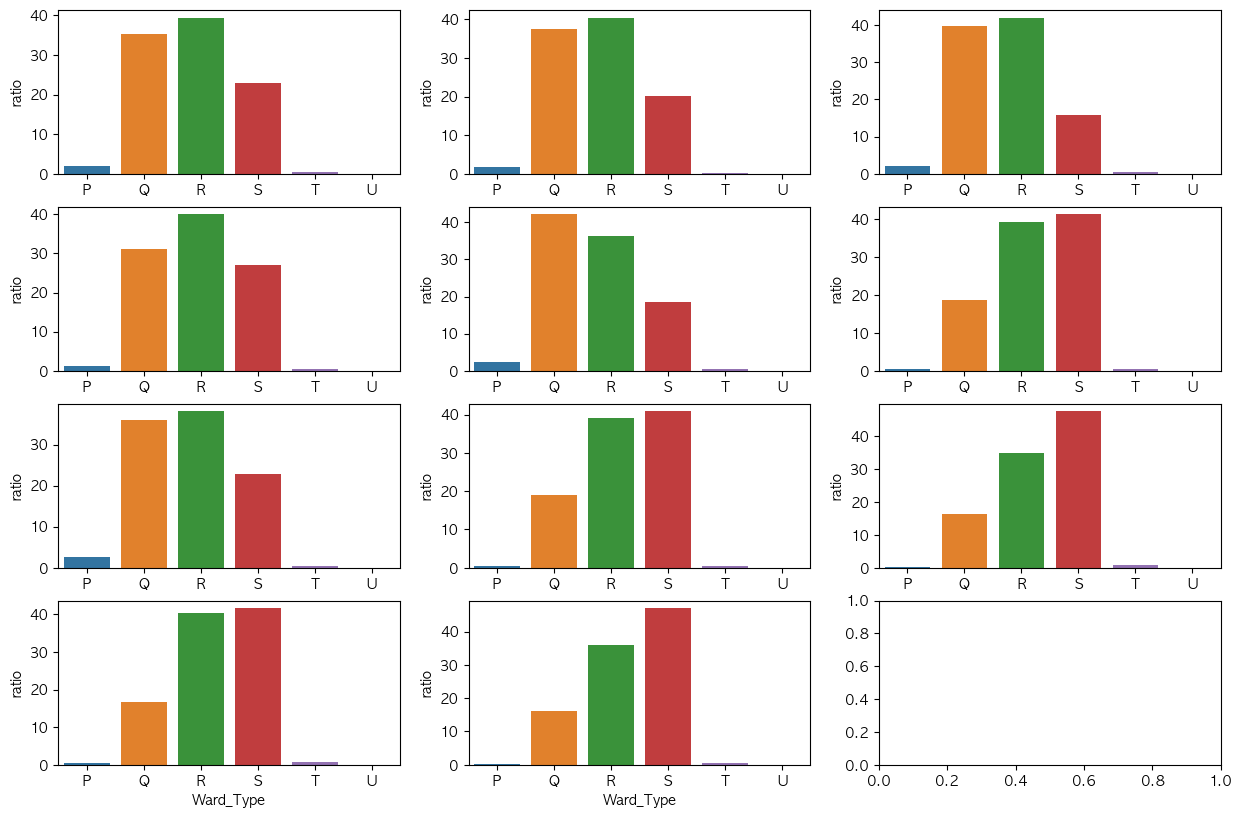

In [44]:
fig, axes = plt.subplots(figsize=(15,10), nrows=4, ncols=3, dpi=100)
fig.tight_layout(pad=100)
sns.barplot(data=ward_stay[ward_stay['Stay']=='0-10'], x='Ward_Type', y='ratio', ax=axes[0][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='11-20'], x='Ward_Type', y='ratio', ax=axes[0][1])
sns.barplot(data=ward_stay[ward_stay['Stay']=='21-30'], x='Ward_Type', y='ratio', ax=axes[0][2])
sns.barplot(data=ward_stay[ward_stay['Stay']=='31-40'], x='Ward_Type', y='ratio', ax=axes[1][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='41-50'], x='Ward_Type', y='ratio', ax=axes[1][1])
sns.barplot(data=ward_stay[ward_stay['Stay']=='51-60'], x='Ward_Type', y='ratio', ax=axes[1][2])
sns.barplot(data=ward_stay[ward_stay['Stay']=='61-70'], x='Ward_Type', y='ratio', ax=axes[2][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='71-80'], x='Ward_Type', y='ratio', ax=axes[2][1])
sns.barplot(data=ward_stay[ward_stay['Stay']=='81-90'], x='Ward_Type', y='ratio', ax=axes[2][2])
sns.barplot(data=ward_stay[ward_stay['Stay']=='91-100'], x='Ward_Type', y='ratio', ax=axes[3][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='More than 100 Days'], x='Ward_Type', y='ratio', ax=axes[3][1])

axes[0][0].set_xlabel('')
axes[0][1].set_xlabel('')
axes[0][2].set_xlabel('')
axes[1][0].set_xlabel('')
axes[1][1].set_xlabel('')
axes[1][2].set_xlabel('')
axes[2][0].set_xlabel('')
axes[2][1].set_xlabel('')
axes[2][2].set_xlabel('')

- 각 재원일수별 빈도수 합계를 이용해 비율로 환산
- 오른쪽 방향으로 0~10일부터 100일이상까지
<br><br>
- 병실 유형 비율결과 다음과 같은 재원일수끼리 비슷한 분포를 나타냄
    * 0-10, 11-20, 21-30, 31-40, 61-70
    * 41-50
    * 51-60, 71-80. 91-100
    * 81-90, 100일 이상<br><br>
    
- 또한, 전체적으로 ``R,S 병실의 유형이 모든 재원일수 기간에 가장 많으며``, ``Q병실도 R,S 못지 않게 많이 사용``되고 있다. 그리고 **``R,S,Q 병실유형이 재원일 수기간에 따라 다른 분포를 보인다``**
    
- 따라서, 병실 유형이 재원일수를 예측 시 어느 정도 영향을 미칠 수 있을 듯함.

In [45]:
# 병실 시설코드와 종속변수간의 이원카이스퀘어 검정
ward_stay = train.groupby(['Ward_Facility_Code','Stay']).agg({'Ward_Facility_Code':'count'}).rename(columns={'Ward_Facility_Code':'count'}).reset_index()
ward_stay_pivot = pd.pivot_table(data=ward_stay, values='count', index='Ward_Facility_Code',
              columns='Stay')
from scipy.stats import chi2_contingency

iloc_lst = [ward_stay_pivot.iloc[row].tolist() for row in range(len(ward_stay_pivot))]
chi2, p, df, expected = chi2_contingency(iloc_lst)
expected_df = pd.DataFrame(data=np.round(expected,0), index=ward_stay_pivot.index,
                          columns=ward_stay_pivot.columns)

print("카이스퀘어 검정통계량: ", chi2)
print("P-value: ", p)
print("자유도: ", df)
expected_df

카이스퀘어 검정통계량:  7507.470145092706
P-value:  0.0
자유도:  50


Stay,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100,More than 100 Days
Ward_Facility_Code,,,,,,,,,,,
A,2069.0,6848.0,7667.0,4834.0,1029.0,3069.0,240.0,899.0,424.0,242.0,586.0
B,2606.0,8627.0,9659.0,6090.0,1296.0,3866.0,303.0,1132.0,534.0,305.0,738.0
C,2629.0,8702.0,9743.0,6143.0,1308.0,3900.0,306.0,1142.0,539.0,308.0,744.0
D,3840.0,12713.0,14235.0,8974.0,1911.0,5697.0,446.0,1668.0,787.0,450.0,1087.0
E,4103.0,13582.0,15208.0,9588.0,2041.0,6087.0,477.0,1782.0,841.0,481.0,1162.0
F,8358.0,27668.0,30979.0,19531.0,4158.0,12399.0,972.0,3631.0,1713.0,979.0,2366.0


- p-value값이 0.0이므로 병실 시설코드와 재원일수간에 관계가 독립이 아니다!

In [46]:
# 어떤 유형의 병실의 재원일수가 긴 편인지 재원일수 비율로 계산하자
ward_stay['stay_sum'] = ''
for i in range(len(ward_stay)):
    ward_stay.loc[i, 'stay_sum'] = stay_sum_dict[ward_stay.loc[i, 'Stay']]

ward_stay['ratio'] = (ward_stay['count'] / ward_stay['stay_sum'])*100
ward_stay['ratio'] = ward_stay['ratio'].astype(float)

In [47]:
# 잠시 Ward_Facility_Code 변수명을 Ward_Type으로 고치기
ward_stay.rename(columns={'Ward_Facility_Code':'Ward_Type'}, inplace=True)

Text(0.5, 292.6787439613526, '')

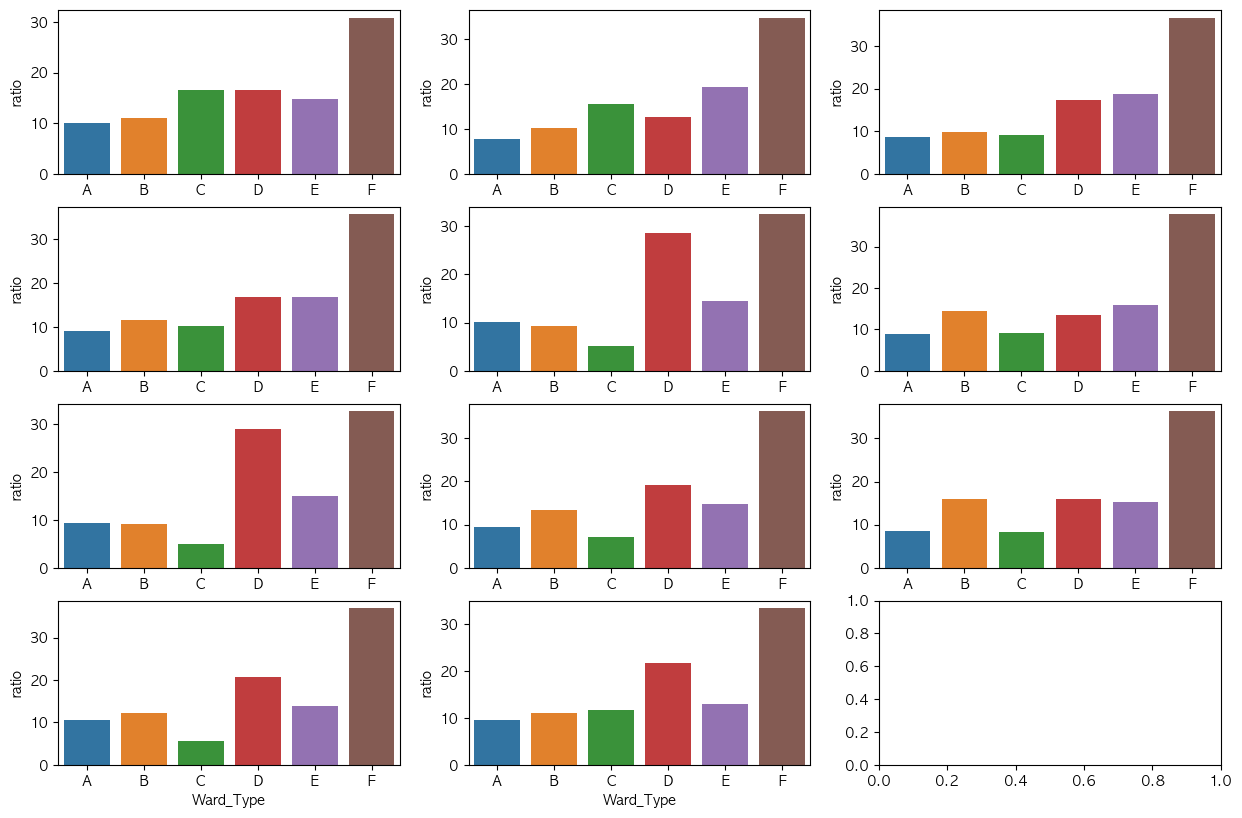

In [48]:
fig, axes = plt.subplots(figsize=(15,10), nrows=4, ncols=3, dpi=100)
fig.tight_layout(pad=100)
sns.barplot(data=ward_stay[ward_stay['Stay']=='0-10'], x='Ward_Type', y='ratio', ax=axes[0][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='11-20'], x='Ward_Type', y='ratio', ax=axes[0][1])
sns.barplot(data=ward_stay[ward_stay['Stay']=='21-30'], x='Ward_Type', y='ratio', ax=axes[0][2])
sns.barplot(data=ward_stay[ward_stay['Stay']=='31-40'], x='Ward_Type', y='ratio', ax=axes[1][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='41-50'], x='Ward_Type', y='ratio', ax=axes[1][1])
sns.barplot(data=ward_stay[ward_stay['Stay']=='51-60'], x='Ward_Type', y='ratio', ax=axes[1][2])
sns.barplot(data=ward_stay[ward_stay['Stay']=='61-70'], x='Ward_Type', y='ratio', ax=axes[2][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='71-80'], x='Ward_Type', y='ratio', ax=axes[2][1])
sns.barplot(data=ward_stay[ward_stay['Stay']=='81-90'], x='Ward_Type', y='ratio', ax=axes[2][2])
sns.barplot(data=ward_stay[ward_stay['Stay']=='91-100'], x='Ward_Type', y='ratio', ax=axes[3][0])
sns.barplot(data=ward_stay[ward_stay['Stay']=='More than 100 Days'], x='Ward_Type', y='ratio', ax=axes[3][1])

axes[0][0].set_xlabel('')
axes[0][1].set_xlabel('')
axes[0][2].set_xlabel('')
axes[1][0].set_xlabel('')
axes[1][1].set_xlabel('')
axes[1][2].set_xlabel('')
axes[2][0].set_xlabel('')
axes[2][1].set_xlabel('')
axes[2][2].set_xlabel('')

- 전체 재원일수 기간을 통들어 ``F 시설코드가 압도적으로 가장 많았다. 일반적으로 사용되는 시설인듯`` 하다.
- 전체적인 병실시설 분포가 동일하지만 ``D병실시설`` 같은경우, `41-50, 61-70 재원일수 기간에 두드러지게 많은 비율을 차지`했다. 또한 ``C병실 시설``같은 경우, 재원일수에 따라 상이한 비율을 띈다.

**``따라서, 병실(Ward) 유형과 병실 시설 코드와 종속변수(Stay)간의 관계는 서로 독립이 아니다``**

#### 네 번째 가설 검정
- 침실(bed) 등급에 따라 재원 기간 수가 유의미한 차이를 보일 것이다.
    * 침실 등급은 병실(Ward) 유형과 병실 시설 코드, 입원 보증금과 연관이 있을 것이므로 3가지 변수 함께 분석 시도<br><br>
    
- **``침실등급과 입원 보증금간의 관계도 없을 뿐더러 각 두 변수와 재원일수간의 관계 존재 안 함``**
- **``병실 유형과 병실 시설 코드와 재원일수간의 관계는 존재``**
    * R,S,Q 병실 유형이 재원일수에 따라 비율 분포가 다르다
    * C,D 병실시설코드가 재원일수에 따라 비율 분포가 다르다<br><br>
    
- 따라서, 네 번째 가설은 일부만 채택!

### 다섯번째 가설

- 환자 입원 유형과 입원 당일 질병의 심각성 간의 관계를 살펴보고 이 변수들과 재원기간 수와 관계가 있는지 살펴보기(귀무가설:관계가 없다.)

#### 환자 입원 유형과 입원 당일 질병의 심각성 관계

In [49]:
# Type of Admission(입원 유형), Severity of Illness(질환 심각성), Stay(재원일수)
four_df = train[['Type of Admission','Severity of Illness', 'Stay']]

In [50]:
# 입원 유형과 병 심각성 변수의 level들 관찰하기
print(f"###입원 유형 level:\n{four_df['Type of Admission'].value_counts()}")
print()
print(f"###질병의 심각성 level:\n{four_df['Severity of Illness'].value_counts()}")

###입원 유형 level:
Trauma       152261
Emergency    117676
Urgent        48501
Name: Type of Admission, dtype: int64

###질병의 심각성 level:
Moderate    175843
Minor        85872
Extreme      56723
Name: Severity of Illness, dtype: int64


- 입원 유형 level 3개 모두 대략적으로 **심각함**을 의미한다. 이 3가지 간의 차이점을 알기 위해서는 ``도메인 지식이 필요..``
- 질병의 심각성 level 3개는 그래도 ``서열척도가 담겨있다``
<br><br>
- 그렇다면 입원 유형 level과 질병의 심각성 level 값 매핑이 어떻게 될까?
- 질병의 심각성 level 중 **Moderate**값이 대부분이다..

In [51]:
# 입원유형과 질병의 심각성 두 가지 기준으로 그룹핑해서 빈도수를 파악해보자
# 질병의 심각성의 서열 척도가 명확하니 질병의 심각성을 1차 기준으로 설정
group_df = four_df.groupby(['Severity of Illness','Type of Admission']).agg({'Type of Admission':'count'}).rename(columns={'Type of Admission':'count'}).reset_index()
group_df

,Severity of Illness,Type of Admission,count
0,Extreme,Emergency,19844
1,Extreme,Trauma,28837
2,Extreme,Urgent,8042
3,Minor,Emergency,35356
4,Minor,Trauma,36800
5,Minor,Urgent,13716
6,Moderate,Emergency,62476
7,Moderate,Trauma,86624
8,Moderate,Urgent,26743


In [52]:
# 질병의 심각성 마다 총 입원환자수가 다르기 때문에 비율로 환산하기 위해 질병의 심각성 각 level의 빈도수 총합을 구하자
severity = four_df.groupby('Severity of Illness').agg({'Severity of Illness':'count'}).rename(columns={'Severity of Illness':'count'}).reset_index()
severity

,Severity of Illness,count
0,Extreme,56723
1,Minor,85872
2,Moderate,175843


In [53]:
# dict comprehension을 이용해 이중리스트를 1차원의 dict형태로 바꾸기!
groups = severity.values.tolist()
severity_dict = {group[0]:group[1] for group in groups}
severity_dict

{'Extreme': 56723, 'Minor': 85872, 'Moderate': 175843}

In [54]:
# 질병 심각성 level의 각 총합계가 들어있는 dict를 이용해서 four_df 데이터프레임에서 총 합계 변수 생성
group_df['severity_sum'] = ''
for idx in range(len(group_df)):
    group_df.loc[idx, 'severity_sum'] = severity_dict[group_df.loc[idx, 'Severity of Illness']]

In [55]:
# '비율' 파생변수 생성
group_df['ratio'] = (group_df['count'] / group_df['severity_sum']) * 100
group_df['ratio'] = group_df['ratio'].astype(float)
group_df['ratio'] = group_df['ratio'].round(3)

In [56]:
group_df

,Severity of Illness,Type of Admission,count,severity_sum,ratio
0,Extreme,Emergency,19844,56723,34.984
1,Extreme,Trauma,28837,56723,50.838
2,Extreme,Urgent,8042,56723,14.178
3,Minor,Emergency,35356,85872,41.173
4,Minor,Trauma,36800,85872,42.854
5,Minor,Urgent,13716,85872,15.973
6,Moderate,Emergency,62476,175843,35.529
7,Moderate,Trauma,86624,175843,49.262
8,Moderate,Urgent,26743,175843,15.208


In [57]:
# count(빈도수)변수를 가지고 질병의 심각성과 입원 유형간의 관계 통계적 검정을 위해 이원 카이스퀘어 검정 실행
# 우선 pivot_table형태로 만들기
pivot_df = pd.pivot_table(data=group_df[['Severity of Illness','Type of Admission','count']],
                         index='Severity of Illness', columns='Type of Admission', values='count')
pivot_df

Type of Admission,Emergency,Trauma,Urgent
Severity of Illness,,,
Extreme,19844,28837,8042
Minor,35356,36800,13716
Moderate,62476,86624,26743


In [58]:
# 이원 카이스퀘어 검정 수행후 결과 
from scipy.stats import chi2_contingency

# 검정할 데이터 행 하나의 리스트에 담기
iloc_lst = [pivot_df.iloc[i].tolist() for i in range(len(pivot_df))]

chi2, p, df, expected = chi2_contingency(iloc_lst)
expected_df = pd.DataFrame(data=np.round(expected,0), index=pivot_df.index, columns=pivot_df.columns)
print(f"#이원 카이스퀘어 검정 통계량: {chi2: 4f}")
print(f"#P-value: {p:.4f}")
print(f"#자유도: {df}")
expected_df

#이원 카이스퀘어 검정 통계량:  1269.494825
#P-value: 0.0000
#자유도: 4


Type of Admission,Emergency,Trauma,Urgent
Severity of Illness,,,
Extreme,20961.0,27122.0,8639.0
Minor,31733.0,41060.0,13079.0
Moderate,64981.0,84079.0,26782.0


- P-value가 0.05 유의수준보다 작으므로 귀무가설을 기각
- 즉, ``질환 심각성과 입원 유형에는 관계가 존재``

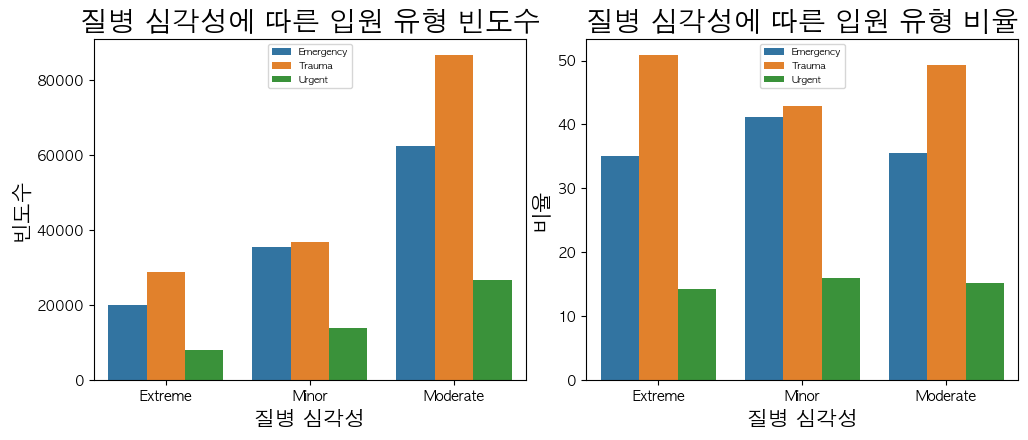

In [59]:
fig, axes = plt.subplots(figsize=(10,4), ncols=2, dpi=100)
fig.tight_layout()
names = ['빈도수','비율']
sns.barplot(data=group_df, x='Severity of Illness', y='count', hue='Type of Admission', ax=axes[0])
sns.barplot(data=group_df, x='Severity of Illness', y='ratio', hue='Type of Admission', ax=axes[1])

for i, name in enumerate(names):
    axes[i].set_title(f"질병 심각성에 따른 입원 유형 {name}", fontsize=20)
    axes[i].set_xlabel("질병 심각성", fontsize=15)
    axes[i].set_ylabel(name, fontsize=15)
    axes[i].legend(loc='upper center', prop={'size':7})
plt.show()

**``입원 유형 Emergency, Trauma, Urgent 차이점``** -> 출처:<a href='https://www.providence.org/services/emergency-care/emergency-trauma-or-urgent-care'>Providence link</a>
- Emergency 
    * 주로 응급실로 들어오는 질병이나 사고로, 때로는 ``목숨이 위태로울 정도의 환자들도 있음.`` 하지만 100% 모두 생명에 지장이 있을 질환은 아니며 ``지속 구토나 설사 등과 같은 목숨은 위태롭게 하지 않지만 처치가 시급한 질병으로도 응급실을 찾기도 한다.``
<br><br>
- Trauma 
    * ``Emergency에서 볼 수 있는 질환과 상처들도 다루며`` 추가적으로 ``트라우마가 있는 상처를 갖고 있는 환자들(교통사고, 총상, 철도사고 등)도 포괄하여 케어``한다.  
<br><br>
- Urgent 
    * ``생명을 위태롭게 하지 않는 질환들을 가진 환자들을 케어``한다. 비용도 응급실과 트라우마에 비해 저렴하며 환자들이 빨리 치료받고 병원을 떠남(환자 회전율이 좋음) 또 응급실에 적합한 환자들을 그곳으로 제시간에 옮겨주도록 도와주며, 개인 건강 계획도 세워주도록 도와줌

**빈도수 그래프**
- 질병이 Moderate한 상태의 환자들이 가장 많이 입원함<br><br>

**비율 그래프**
- 질병 심각성에 따라 Urgent라는 입원 유형 비율이 거의 동일하다.
- Emergeny라는 입원 유형은 Minor라는 질병 심각성일 때 가장 비율이 높았다.(나머지 두 level의 질병 심각성에서 Emergeny입원유형 비율 거의 동일)
- Trauma라는 입원 유형은 Extreme, Moderate라는 질병 심각성일 때 가장 비율이 높았다.<br><br>

**최종 해석**
- 질병이 ``Minor``인 상태: 입원 유형이 주로 ``Trauma 또는 Emergency``일 가능성 매우 높음
- 질병이 ``Moderate``인 상태: 입원 유형이 주로 ``Trauma``일 가능성 매우 높음
- 질병이 ``Extreme``인 상태: 입원 유형이 주로 ``Trauma``일 가능성 매우 높음

##### 질병심각성과 재원일수 간의 관계

- 질병심각성과 재원일수 모두 **Ordinal(서열형)** 척도.. 
- Order를 설정하고 그 **Order에 따라 레이블인코딩**으로 서열이 들어있는 수치값으로 바꿔주자

<스피어만 상관계수>
- 두 연속형 변수의 분포가 심각하게 정규분포를 벗어나거나
- 순위 척도일 때 

<켄달 상관계수>
- 순위 척도 자료 또는 순위 척도로 변환한 자료를 이용할 때
- 이 값도 피어슨, 스피어만처럼 -1 ~ 1 사이값으로 출력

In [60]:
# 질병 심각성 level 서열 지정하기
severity_order = ['Minor','Moderate','Extreme']
four_df['Severity of Illness'] = pd.Categorical(values=four_df['Severity of Illness'], categories=severity_order, ordered=True)

In [61]:
from sklearn.preprocessing import LabelEncoder
cols = ['Severity of Illness','Stay']
encoders = {}
for col in cols:
    encoders[col] = LabelEncoder()
    four_df[col] = encoders[col].fit_transform(four_df[col])

In [62]:
# 켄달상관계수는 스피어만 상관계수에 비해 똑같은 level값이 많을 때 사용한다고 알려져 있음 -> 교수님 보완답변 기다리기
# 인코딩한 범주형 변수의 level value_counts()해서 동일한 값 많은지 살펴보기
print(f"Severtiy of Illness의 level값들 종류:\n{four_df['Severity of Illness'].value_counts()}")
print()
print(f"Stay의 level값들 종류:\n{four_df['Stay'].value_counts()}")

Severtiy of Illness의 level값들 종류:
2    175843
1     85872
0     56723
Name: Severity of Illness, dtype: int64

Stay의 level값들 종류:
2     87491
1     78139
3     55159
5     35018
0     23604
4     11743
7     10254
10     6683
8      4838
9      2765
6      2744
Name: Stay, dtype: int64


- 동일한 level 값들이 많은 것으로 보아 스피어만보다는 ``켄달 상관계수``사용하는 것이 좋을 듯 하다.

In [63]:
# 켄달상관계수 통계적 검정
from scipy.stats import kendalltau

tau, p_value = kendalltau(four_df['Severity of Illness'], four_df['Stay'])
print(f"## 켄델 타우 검정통계량: {tau}")
print(f"## P-value: {p_value}")

## 켄델 타우 검정통계량: -0.003434567627955393
## P-value: 0.021823765120460015


- 켄텔 타우 상관분석의 귀무가설은 **두 변수간 관계가 없다**
<br><br>
- P-value값이 유의수준 0.05보다 작으므로 귀무가설을 기각
- 따라서, ``질병의 심각성과 재원일수 기간 변수간에 관계가 존재한다``

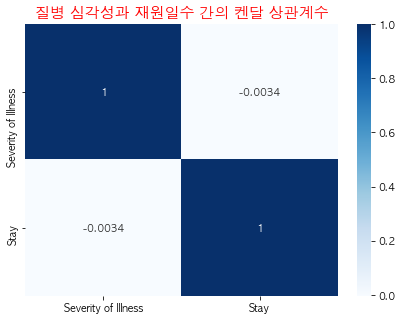

In [64]:
# 켄달상관계수 출력
corr = four_df[['Severity of Illness','Stay']].corr(method='kendall')
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title('질병 심각성과 재원일수 간의 켄달 상관계수',fontsize=15, color='red')
plt.show()

- 통계적 검정은 두 변수간의 관계가 있다고 나왔지만 켄달 상관계수를 출력해본 결과 값이 ``-0.0034``로 ``두 변수 간에 관계가 거의 없다``고 볼 수 있다.

##### 입원유형과 재원일수 간의 관계

- 입원유형 도메인 지식 조사 결과, 입원유형에 따른 질병 심각성이 Emergency > Trauma > Urgent 일것으로 예상
    * 이 파악을 위해서 레이블 인코딩 적용 후 질병 심각성과 상관관계 계수 비교해보기

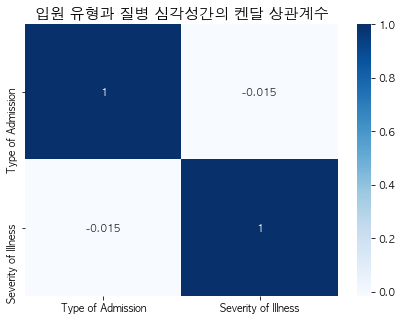

In [65]:
# 입원유형 map함수 통해서 간단하게 레이블인코딩
four_df['Type of Admission'] = four_df['Type of Admission'].map({'Emergency':2, 'Trauma':1, 'Urgent':0})

# 레이블 인코딩한 입원유형과 질병 심각성 켄달상관계수 값 출력해보기
corr = four_df[['Type of Admission','Severity of Illness']].corr(method='kendall')
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("입원 유형과 질병 심각성간의 켄달 상관계수", fontsize=15)
plt.show()

- 입원 유형과 질병 심각성간의 켄달 상관계수값은 ``-0.015``로 두 변수 간 관계는 거의 ``독립적``이라고 볼 수 있다.

In [66]:
# 이제 입원 유형과 재원일수간의 통계적 검정 후 켄달 상관계수 값 시각화
# 켄달상관계수 통계적 검정
from scipy.stats import kendalltau

tau, p_value = kendalltau(four_df['Type of Admission'], four_df['Stay'])
print(f"## 켄델 타우 검정통계량: {tau}")
print(f"## P-value: {p_value}")

## 켄델 타우 검정통계량: -0.047024816109112126
## P-value: 5.297964610550388e-216


- P-value값이 유의수준 0.05보다 작으므로 해당 귀무가설을 기각
- 따라서, ``입원 유형과 재원일수간의 관계가 있다.``

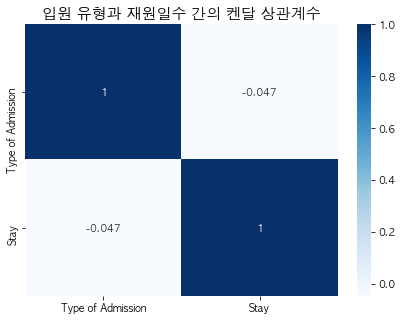

In [67]:
# 실질적인 관계 파악을 위해 상관계수값은 얼마인지 출력
corr = four_df[['Type of Admission','Stay']].corr(method='kendall')
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("입원 유형과 재원일수 간의 켄달 상관계수", fontsize=15)
plt.show()

- 켄달 상관계수값이 ``-0.047``로 두 변수간의 관계가 거의 ``독립적``이라고 볼 수 있다.

#### 다섯번째 가설 검정

- **``환자 입원 유형과 입원 당일 질병의 심각성, 그리고 재원일수 간의 관계는 독립적이다.``**

### 여섯번째 가설

- 환자 연령이 높을수록 재원기간 수가 길 것이다.

In [68]:
# 연령대와 재원일수 변수 추출
age_stay = train[['Age','Stay']]

In [69]:
# 둘 다 범주형 변수이므로 동일한 level값들의 개수를 살펴보고 스피어만/켄달 상관계수 중 선택하기
print("연령대 변수 level counts:\n", age_stay['Age'].value_counts())
print()
print("재원일수 변수 level counts:\n", age_stay['Stay'].value_counts())

연령대 변수 level counts:
 41-50     63749
31-40     63639
51-60     48514
21-30     40843
71-80     35792
61-70     33687
11-20     16768
81-90      7890
0-10       6254
91-100     1302
Name: Age, dtype: int64

재원일수 변수 level counts:
 21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64


- 동일한 level값들의 데이터가 두 변수 모두 많으므로 ``켄달 상관계수``로 관계 분석

In [70]:
# Age 변수를 레이블인코딩하기 전 Age level들의 순서 올바르게 정렬됬는지 확인 -> 이미 순서가 잘 정렬되어 있음
# 참고로 Stay level 순서는 이전에 올바르게 설정해놓음
age_stay['Age'].sort_values()

252442      0-10
99406       0-10
99407       0-10
280246      0-10
280247      0-10
           ...  
159985    91-100
159986    91-100
159987    91-100
287346    91-100
155776    91-100
Name: Age, Length: 318438, dtype: object

In [71]:
from sklearn.preprocessing import LabelEncoder
encoder = {}
cols = ['Age','Stay']
for col in cols:
    encoder[col] = LabelEncoder()
    age_stay[col] = encoder[col].fit_transform(age_stay[col])

In [72]:
tau, p_value = kendalltau(age_stay['Age'], age_stay['Stay'])
print(f"## 켄델 타우 검정통계량: {tau}")
print(f"## P-value: {p_value}")

## 켄델 타우 검정통계량: 0.07007718319174233
## P-value: 0.0


- p-value값이 유의수준 0.05보다 작으므로 해당 귀무가설을 기각
- 따라서, ``연령대와 재원일수 간에 관계가 존재``

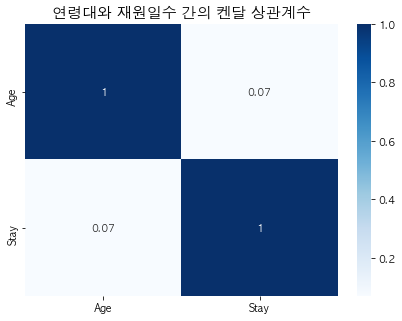

In [75]:
# 실질적인 관계 파악을 위해 상관계수값은 얼마인지 출력
corr = age_stay[['Age','Stay']].corr(method='kendall')
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap='Blues', annot=True)
plt.title("연령대와 재원일수 간의 켄달 상관계수", fontsize=15)
plt.show()

#### 여섯번째 가설 검정

- ``켄달 상관계수 값이 0.07로 실질적으로 선형관계는 존재하지 않음``

### 기타 EDA
#### 환자 거주 도시 id에 따라 재원기간 수 차이
- 입원환자가 거주하는 도시의 병원을 찾은 사람들은 몇 명인지 살펴보기

In [141]:
# 병원이 위치한 도시 코드, 환자 거주 도시 코드, 재원일수 변수 추출
city_stay = train[['City_Code_Hospital','City_Code_Patient','Stay']]
city_stay.head()

,City_Code_Hospital,City_Code_Patient,Stay
0,3,7.0,0-10
1,5,7.0,41-50
2,1,7.0,31-40
3,2,7.0,41-50
4,2,7.0,41-50


In [142]:
# 병원 도시 코드와 환자 거주 도시 코드 간의 unique한 값들 비교
print("# 병원 도시 코드 level:\n", city_stay['City_Code_Hospital'].unique())
print()
print("# 환자거주 도시 코드 level:\n", city_stay['City_Code_Patient'].unique())

# 병원 도시 코드 level:
 [ 3  5  1  2  6  9 10  4 11  7 13]

# 환자거주 도시 코드 level:
 [ 7.  8.  2.  5.  6.  3.  4.  1.  9. 14. nan 25. 15. 12. 10. 28. 24. 23.
 20. 11. 13. 21. 18. 16. 26. 27. 22. 19. 31. 34. 32. 30. 29. 37. 33. 35.
 36. 38.]


In [143]:
# 환자 거주 도시 코드 결측치 개수 확인
city_stay['City_Code_Patient'].isnull().sum()

4532

In [144]:
# 환자 거주 도시 코드가 결측치인 데이터들의 병원 도시 코드는 주로 무엇인지 살펴보기
city_stay[city_stay['City_Code_Patient'].isnull()]['City_Code_Hospital'].value_counts()

1     1170
6      754
2      631
3      401
5      362
9      330
7      318
4      277
11     190
10      61
13      38
Name: City_Code_Hospital, dtype: int64

- 1번 도시에 위치한 병원에서 **환자 거주 도시 코드가 결측치**인 데이터가 가장 많았다.
- 1번 도시는 X지역에 속해있으며 X지역에는 대부분의 입원환자를 받고 있는 ``a병원(대형병원으로 추론됨)``이 있음
<br>
- 또한, 두번째로 결측치가 가장 많았던 곳은 6번 도시의 병원이며 6번 도시도 X지역에 속해있으며 결국 ``a병원``에서 발생했음을 추론할 수 있다.
<br>
- 3번째로 가장 많았던 2번 도시의 병원은 Y지역에 속해있는데, Y지역에는 b,a병원이 거의 동일한 비율로 입원 환자의 대부분은 받았음. 결국 2번 도시 병원의 **환자 거주 도시 코드 결측치**또한 ``a병원``에서 나왔을 가능성이 높음.

``이 사실로 a병원에게 의료정보 데이터를 수집하고 적재하는 과정에서 권고할만한 안건이 될 수 있지 않을까..?``

In [145]:
# 환자 거주 도시 코드 결측치 비율
city_stay['City_Code_Patient'].isnull().sum() / city_stay.shape[0]

0.014231969802598936

- 어찌됬던 **환자 거주 도시 코드 결측치** 비율은 전체 데이터의 1.1%밖에 되지 않기 때문에 과감히 결측치 데이터를 삭제하자.

In [146]:
city_stay = city_stay.dropna()
city_stay.isnull().sum().sum()

0

In [147]:
# 입원환자가 거주하는 도시의 병원을 찾은 사람들은 몇 명인지 살펴보기
# 환자 거주 도시 코드 int형으로 바꾸어주기
city_stay['City_Code_Patient'] = city_stay['City_Code_Patient'].astype(int)
city_stay['same_ohe'] = ''

In [148]:
# 환자가 거주하는 도시와 병원이 위치한 도시가 일치하면 1, 아니면 0으로 하는 파생변수 생성
# 함수 정의해서 apply는 너무 느림.. => pandas의 loc과 조건문을 사용하자!!!!!
city_stay.loc[(city_stay['City_Code_Hospital'] == city_stay['City_Code_Patient']), 'same_ohe'] = 1
city_stay.loc[(city_stay['City_Code_Hospital'] != city_stay['City_Code_Patient']), 'same_ohe'] = 0

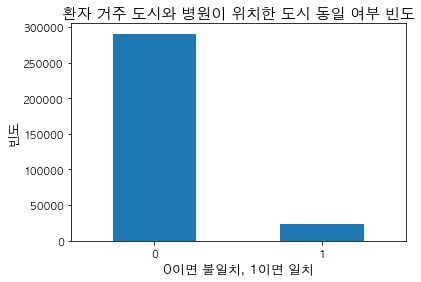

In [156]:
city_stay.groupby('same_ohe').agg({'same_ohe':'count'}).rename(columns={'same_ohe':'count'}).plot.bar(legend=None)
plt.title("환자 거주 도시와 병원이 위치한 도시 동일 여부 빈도", fontsize=15)
plt.xticks(rotation=0)
plt.xlabel('0이면 불일치, 1이면 일치', fontsize=13)
plt.ylabel('빈도', fontsize=13)
plt.show()

- 병원이 위치한 도시에 거주하는 입원환자들 비율은 매우 낮다
- ``따라서 모든 병원의 입원환자 대부분은 해당 병원이 위치한 도시에서 오지 않았을 가능성이 매우 높음``

#### 환자와 동반된 방문객 수에 따라 재원기간 수 차이

In [158]:
# 환자 동반 방문객 수와 재원일수 변수 추출
visit_stay = train[['Visitors with Patient','Stay']]

In [161]:
# 환자 동반 방문객 수 기술 통계량 살펴보기
visit_stay['Visitors with Patient'].describe()

count    318438.000000
mean          3.284099
std           1.764061
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          32.000000
Name: Visitors with Patient, dtype: float64

<AxesSubplot:xlabel='Visitors with Patient'>

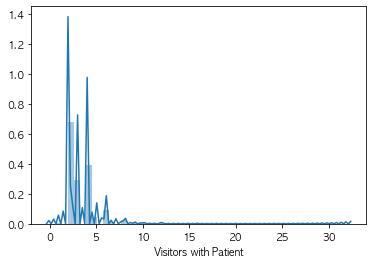

In [162]:
# 방문객 수 분포 그려보기
sns.distplot(visit_stay['Visitors with Patient'])

<AxesSubplot:ylabel='Visitors with Patient'>

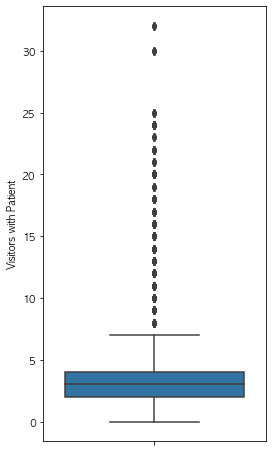

In [169]:
# boxplot으로 그려보기
plt.figure(figsize=(4,8))
sns.boxplot(visit_stay['Visitors with Patient'], orient='v')

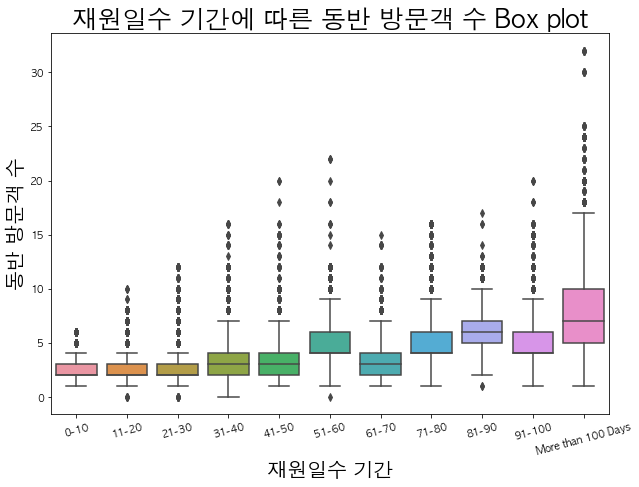

In [181]:
# 재원일수 범위에 따른 환자 동반 방문객 수 boxplot
plt.figure(figsize=(10,7))
sns.boxplot(data=visit_stay, x='Stay', y='Visitors with Patient')
plt.xticks(rotation=15)
plt.title("재원일수 기간에 따른 동반 방문객 수 Box plot", fontsize=25)
plt.xlabel('재원일수 기간', fontsize=20)
plt.ylabel('동반 방문객 수', fontsize=20)
plt.show()

- ``Boxplot 그래프상 재원일수 기간이 길어질수록 동반 방문객 수의 평균값이 점점 증가하는 듯`` 하다.
- 재원일수를 서열값을 가진 형태로 Label encoding실시한 후 ``상관분석``과 ``산점도`` 그려보자.

In [186]:
# 재원일수 LabelEncoding실시
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
visit_stay['Stay'] = encoder.fit_transform(visit_stay['Stay'])

<AxesSubplot:xlabel='Stay', ylabel='Visitors with Patient'>

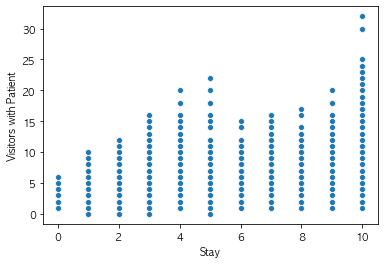

In [191]:
# 방문객 수와 재원일수 간의 산점도 그리기
sns.scatterplot(data=visit_stay, x='Stay', y='Visitors with Patient')

- 재원일수 기간 level이 증가할수록 방문객수도 약간 증가하는 선형관계가 있는 듯 하다!

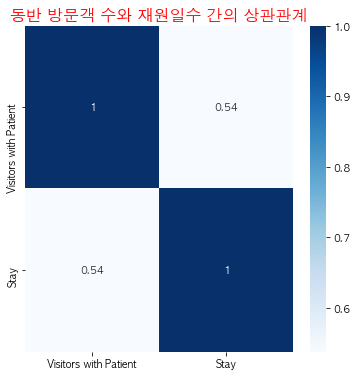

In [198]:
# 상관계수 계산
corr = visit_stay.corr()
plt.figure(figsize=(6,6))
plt.title("동반 방문객 수와 재원일수 간의 상관관계", fontsize=16, color='red')
sns.heatmap(data=corr, annot=True, cmap='Blues')
plt.show()

- 상관계수가 **``0.54``** 로 매우 높은 양의 상관관계를 보임을 알 수 있다.
- 따라서, ``동반 방문객 수가 많을수록 병원에 입원하는 재원일수 기간이 증가하는 선형관계가 존재한다.``
- **``추후 모델링 시 매우 중요한 변수로 작용할 것으로 예상``**